# Analisi sulla porbabilità di licenziamento di un dipendente

Programmazione di Applicazioni Data Intensive
Laurea in Ingegneria e Scienze Informatiche
DISI - Università di Bologna, Cesena

- Tommaso Ceredi
- Leonardo Marcaccio

Citazioni

- IBM HR Analytics Employee Attrition & Performance
Rohan’s Four - Rohan Jain, Ali Shahid, Sehrish Saud, Julian Ramirez

# Descrizione del problema

Si deve realizzare un modello che, utilizzando i dati registrati da IBM relativi ai propri dipendenti, sia in grado di predire una variabile discreta binaria.

# Analisi del Dataset

Il dataset contiene **1470 record** e **35 colonne**, ciascuna rappresentante un attributo relativo ai dipendenti.
Ecco una panoramica delle colonne:
1. **Age**: Età del dipendente (valore intero).
2. **Attrition**: Indica se il dipendente ha lasciato l'azienda (Sì o No).
3. **BusinessTravel**: Frequenza di viaggi di lavoro (Non viaggia, Viaggia raramente, Viaggia frequentemente).
4. **DailyRate**: Tasso giornaliero (valore numerico).
5. **Department**: Reparto di appartenenza del dipendente (es. Vendite, Ricerca e Sviluppo).
6. **DistanceFromHome**: Distanza tra casa e lavoro in chilometri.
7. **Education**: Livello di istruzione (da 1 a 5).
8. **EducationField**: Campo di studi del dipendente (es. Scienze, Umanistiche).
9. **EmployeeCount**: Numero di dipendenti (valore fisso di 1).
10. **EmployeeNumber**: ID univoco del dipendente.
11. **EnvironmentSatisfaction**: Soddisfazione dell'ambiente di lavoro (da 1 a 4).
12. **Gender**: Genere del dipendente (Maschio, Femmina).
13. **HourlyRate**: Tariffa oraria.
14. **JobInvolvement**: Coinvolgimento lavorativo (da 1 a 4).
15. **JobLevel**: Livello di lavoro.
16. **JobRole**: Ruolo lavorativo (es. Manager, Tecnico).
17. **JobSatisfaction**: Soddisfazione lavorativa (da 1 a 4).
18. **MaritalStatus**: Stato civile (Sposato, Single, Divorziato).
19. **MonthlyIncome**: Reddito mensile.
20. **MonthlyRate**: Tasso mensile.
21. **NumCompaniesWorked**: Numero di aziende precedentemente lavorate.
22. **Over18**: Se il dipendente è maggiorenne (valore fisso "Sì").
23. **OverTime**: Se il dipendente lavora straordinari (Sì o No).
24. **PercentSalaryHike**: Percentuale di aumento salariale.
25. **PerformanceRating**: Valutazione delle prestazioni (da 1 a 4).
26. **RelationshipSatisfaction**: Soddisfazione delle relazioni sul lavoro (da 1 a 4).
27. **StandardHours**: Ore di lavoro standard (valore fisso di 80).
28. **StockOptionLevel**: Livello di opzioni azionarie (da 0 a 3).
29. **TotalWorkingYears**: Anni totali di esperienza lavorativa.
30. **TrainingTimesLastYear**: Numero di sessioni di formazione nell'ultimo anno.
31. **WorkLifeBalance**: Equilibrio tra vita e lavoro (da 1 a 4).
32. **YearsAtCompany**: Anni trascorsi in azienda.
33. **YearsInCurrentRole**: Anni nel ruolo attuale.
34. **YearsSinceLastPromotion**: Anni dall'ultima promozione.
35. **YearsWithCurrManager**: Anni passati con l'attuale manager.

Il dataset è completo, senza valori mancanti, ma alcune colonne, principalmente quelle a valori fissi verranno rimosse per ottimizzare il processo di analisi

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf

from collections import Counter

from __future__ import absolute_import, division, print_function

from imblearn.over_sampling import SMOTE

from matplotlib import rcParams

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.utils import resample

from statsmodels.stats.proportion import proportion_confint

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout,Input
from tensorflow.keras.utils import to_categorical

In [65]:
url = "https://raw.githubusercontent.com/LeonardoMarcaccio/ElaboratoDataIntensive/main/Dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv"
dataset = pd.read_csv(url)
dataset.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)
dataset.set_index('EmployeeNumber', inplace=True)
pd.options.display.max_columns = 33
dataset.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


La variabile target sarà l'elemento binario Attrition, mentre le features in esame sono sia categoriche che continue.

Tra le categoriche troviamo:
- Age
- Business Travel
- Department
- Education
- Education Field
- Environment Satisfaction
- Gender
- Job Involvement
- Job Level
- Job Role
- Job Satisfaction
- Marital Status
- Overtime
- Performance Rating
- Relationship Satisfaction
- Stock Option Level
- Work Life Balance


Tra le continue troviamo:
- Daily Rate
- Hourly Rate
- Monthly Income
- Monthly Rate
- Number of Company Worked
- Percent Salary Hike
- Total Working Years
- Training Time Last Year
- Years at the Company
- Years in current Role
- Years since Last Promotion
- Years with current Manager

Inoltre il campo EmployerNumber identifica univocamente i record del dataset, ma che non ha alcuna importanza ai fini dell'analisi, quindi si procede a definire questa colonna come indice del Dataframe Pandas.

In [66]:
dataset.describe()
dataset['Department'].value_counts()

,count
Department,
Research & Development,961
Sales,446
Human Resources,63


Dall'analisi delle varie caratteristiche dei valori delle colonne notiamo che appaiono due valori alquanto interessanti.

In primis possiamo notare che il Minimo della colonna YearsAtCompany è 0 quindi indica che nella compagnia siano presenti dei neoassunti per i quali è altamente improbabile un licenziamento per ogni tipo di valore tranne per questioni personali, indi per cui riteniamo di voler prendere in considerazione solamente coloro che hanno lavorato nell'azienda per almeno un anno.

Un secondo dato che salta all'occhio è il Minimo della colonna YearsInCurrentRole, anchesso 0.

Per lo stesso ragionamento che abbiamo fatto precedentemente crediamo che sia impossibile che una persona appena promossa ad una nuova posizione in azienda decida di licenziarsi o venga licenziata.

Perciò andremo a eliminare dal dataset tutti i neoassunti e coloro che hanno cambiato di ruolo recentemente in quanto è quasi impossibile che possano essere licenziati.

In [67]:
newWorkers = (dataset['YearsAtCompany'] == 0).value_counts().iloc[1]
print("The number of new workers is", newWorkers)

# Calculate the number of role swappers
roleSwappers = (dataset['YearsInCurrentRole'] == 0).value_counts().iloc[1] - newWorkers
print("The number of role swappers is", roleSwappers)

# Calculate the total rows removed
print("Total rows removed", roleSwappers + newWorkers)

dataset = dataset.drop(dataset[(dataset['YearsAtCompany'] == 0) | (dataset['YearsInCurrentRole'] == 0)].index)

The number of new workers is 44
The number of role swappers is 200
Total rows removed 244


Creiamo ora un dataset copia con solo valori in scala numerica per lo studio delle varie colonne

In [68]:
numerical_dataset = dataset.copy()
numerical_dataset['BusinessTravel'] = LabelEncoder().fit_transform(numerical_dataset['BusinessTravel'])
numerical_dataset['Department'] = LabelEncoder().fit_transform(numerical_dataset['Department'])
numerical_dataset['Gender'] = LabelEncoder().fit_transform(numerical_dataset['Gender'])
numerical_dataset['EducationField'] = LabelEncoder().fit_transform(numerical_dataset['EducationField'])
numerical_dataset['JobRole'] = LabelEncoder().fit_transform(numerical_dataset['JobRole'])
numerical_dataset['MaritalStatus'] = LabelEncoder().fit_transform(numerical_dataset['MaritalStatus'])
numerical_dataset['OverTime'] = LabelEncoder().fit_transform(numerical_dataset['OverTime'])

# Analisi delle Variabili Continue

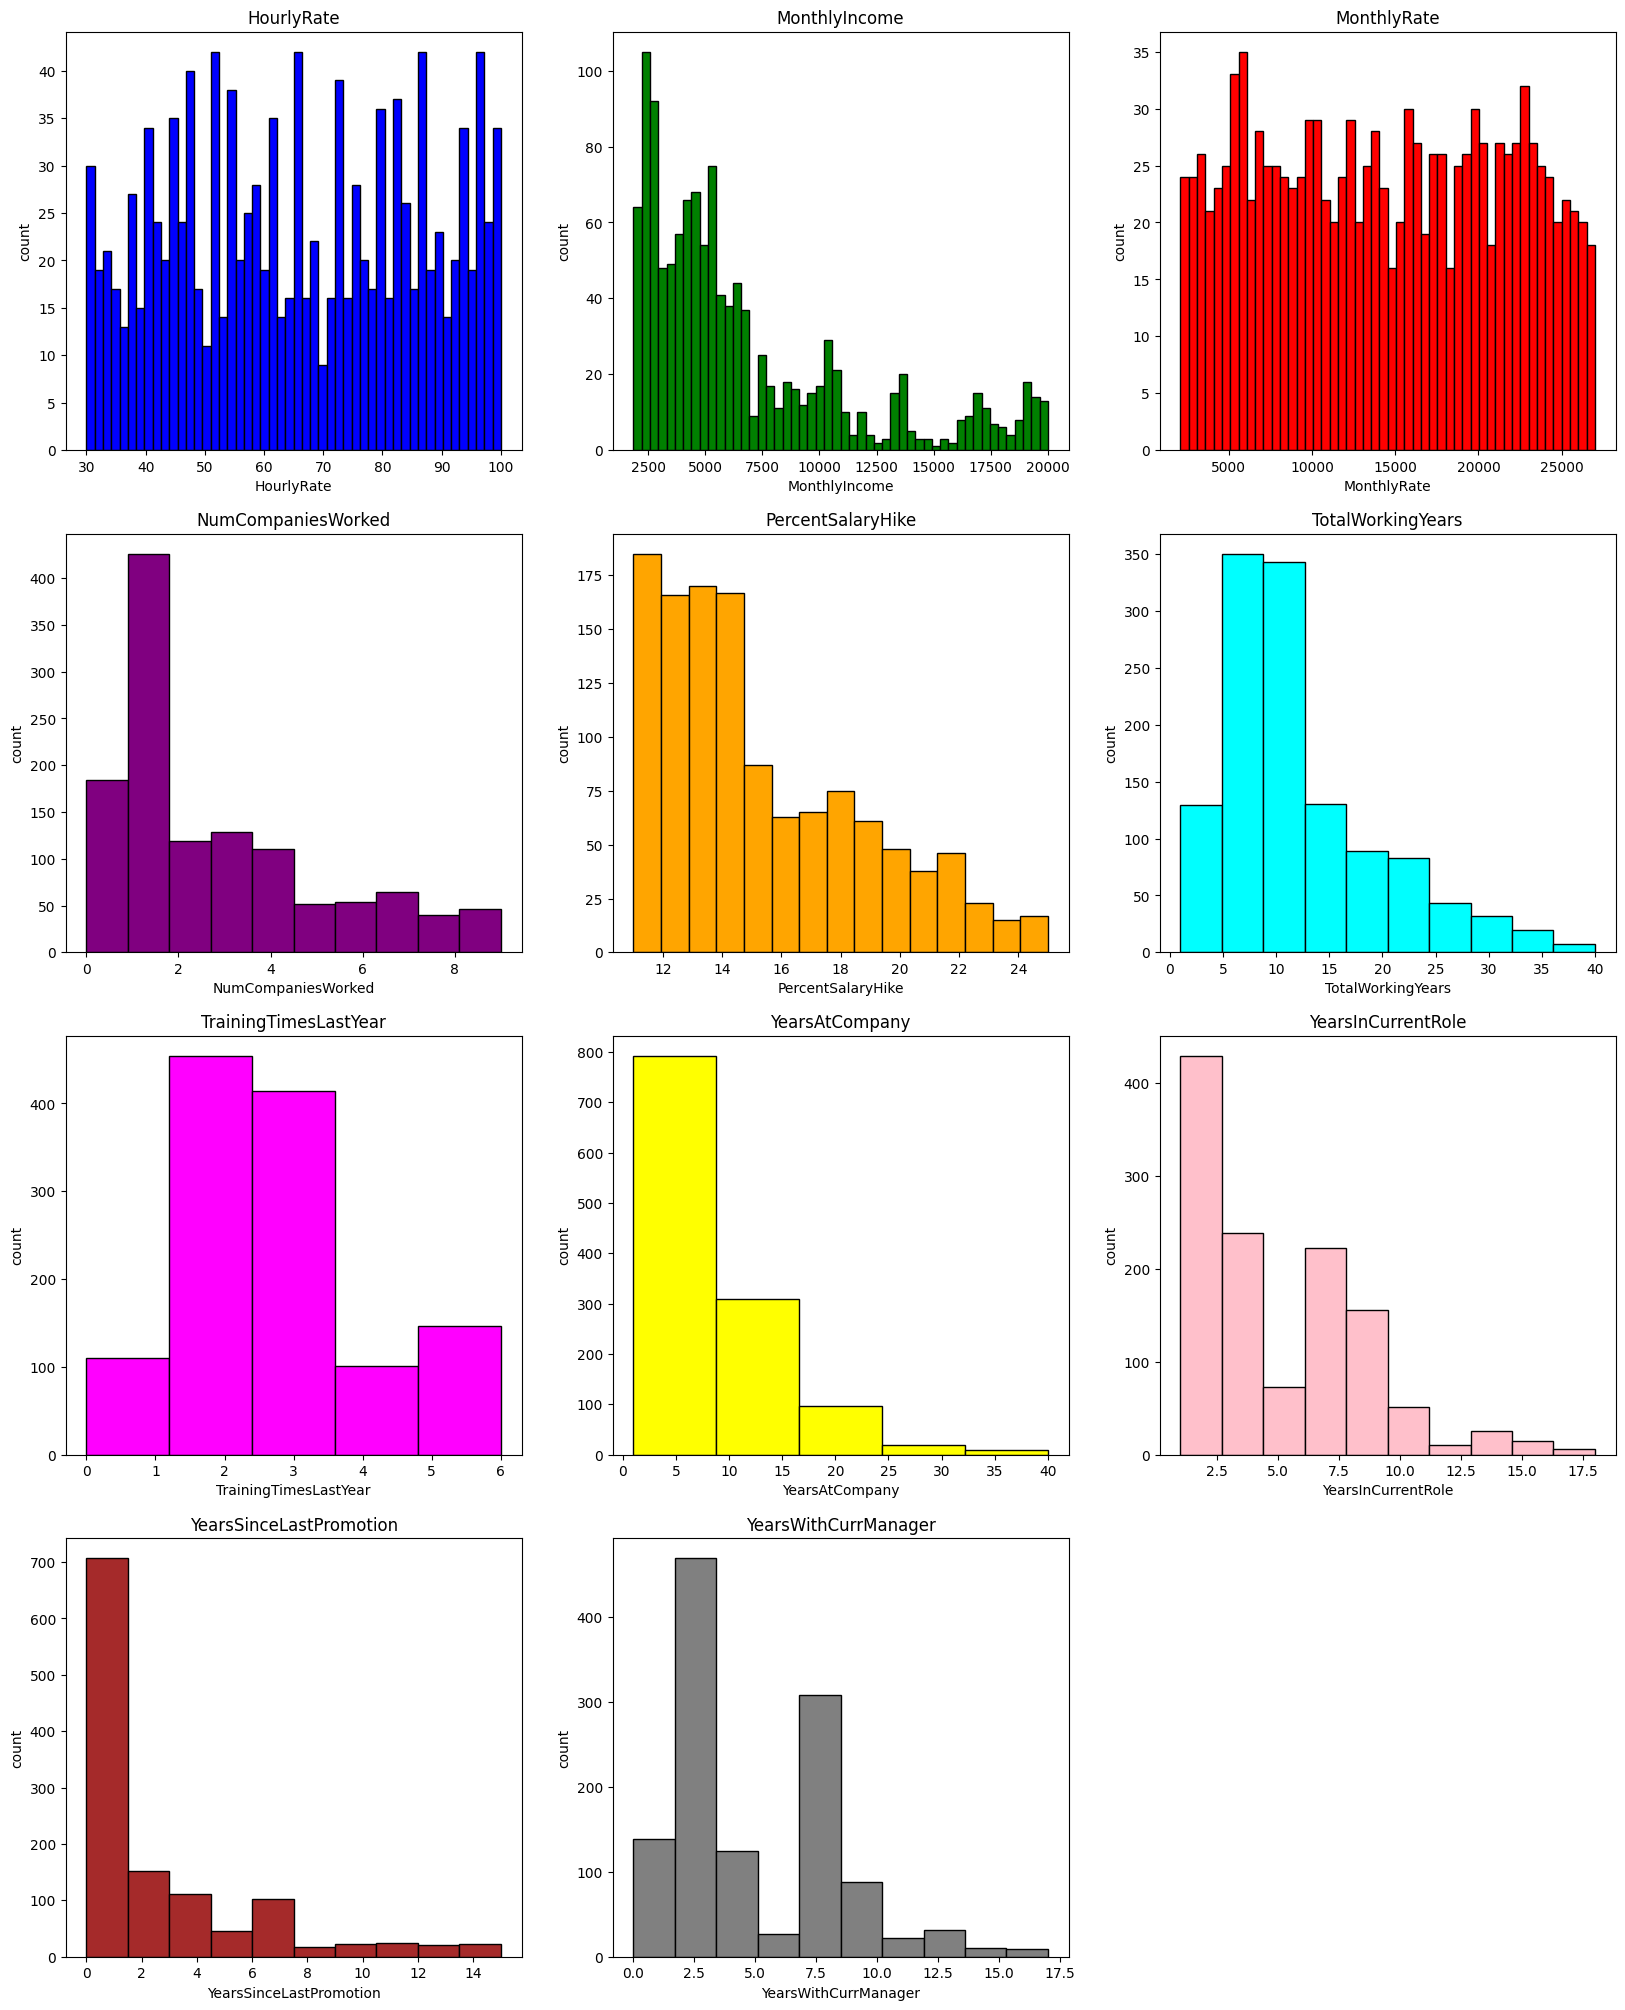

In [69]:
plt.figure(figsize=(20, 25))

colors = ['blue', 'green', 'red', 'purple', 'orange',  'cyan', 'magenta', 'yellow', 'pink', 'brown', 'gray']
continuos_columns = [ 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
bin_size = [50, 50, 50, 10, 15, 10, 5, 5, 10, 10, 10]

for i, column_name in enumerate(continuos_columns):
  plt.subplot(4, 3, i+1)
  plt.title(column_name)
  plt.hist(dataset[column_name], label=column_name, color=colors[i], edgecolor='black', bins=bin_size[i])
  plt.ylabel('count')
  plt.xlabel(column_name)

plt.show()

Dai vari istogrammi si possono notare parecchie caratteristiche importanti come:
- La maggior parte dei dipendenti a più di 5 anni di esperienza
- I dipendenti lavorano con lo stesso manager dai 3 agli 8 anni
- Le promozioni avvengono molto spesso
- I dipendenti lavorano con la compagnia per almeno 15 anni

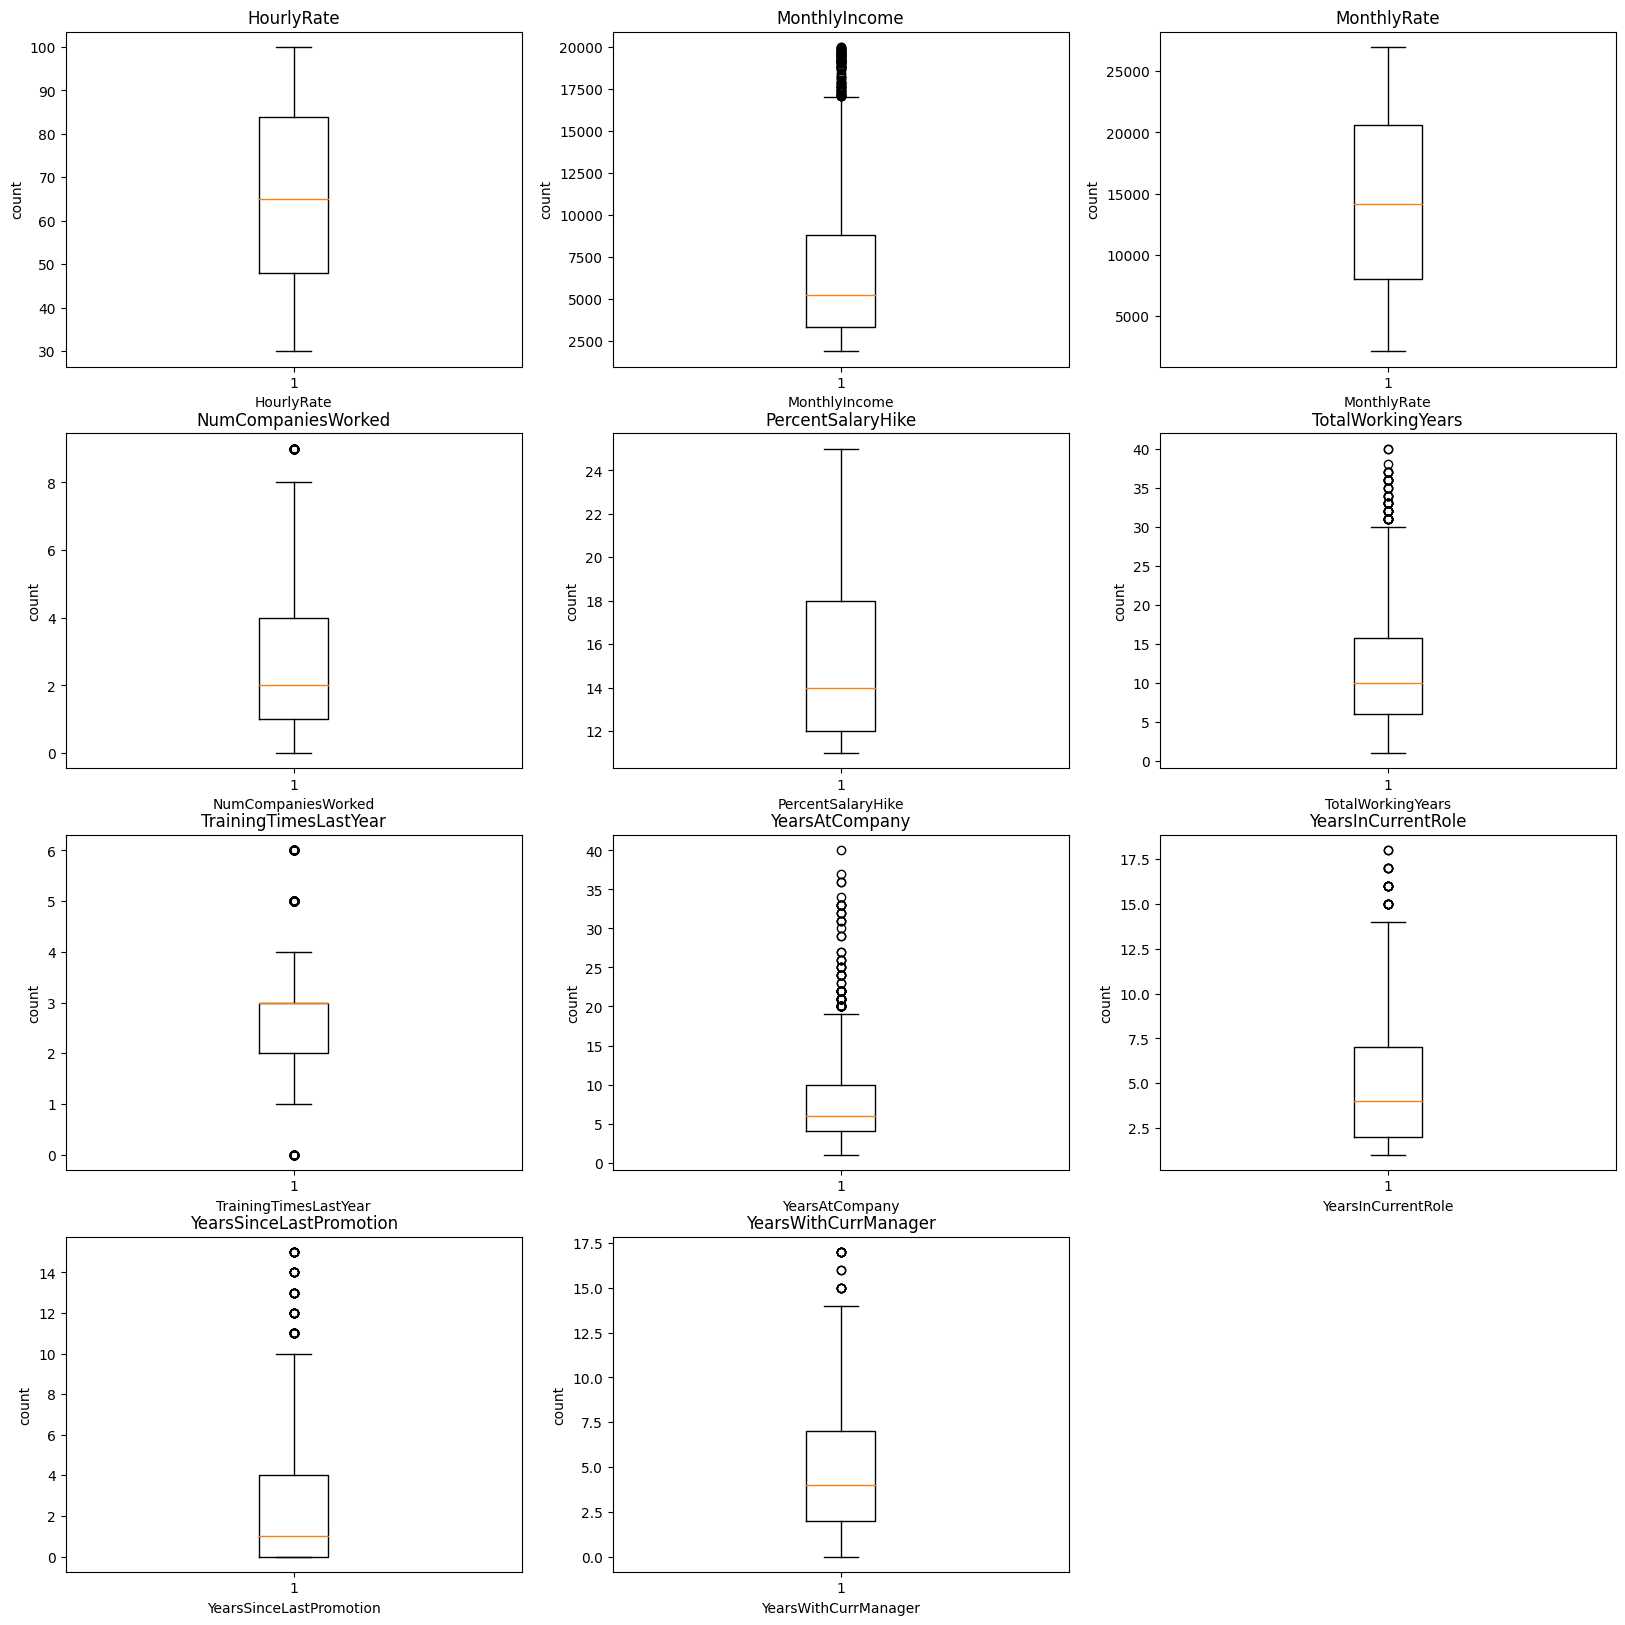

In [70]:
# Boxplot per confrontare alcune variabili rispetto a 'Attrition'
plt.figure(figsize=(20, 20))

for i, column_name in enumerate(continuos_columns):
  plt.subplot(4, 3, i+1)
  plt.title(column_name)
  plt.boxplot(dataset[column_name])
  plt.ylabel('count')
  plt.xlabel(column_name)

plt.show()

# Analisi delle Categorie

Adesso andremo ad analizzare le varie Categorie del nostro data

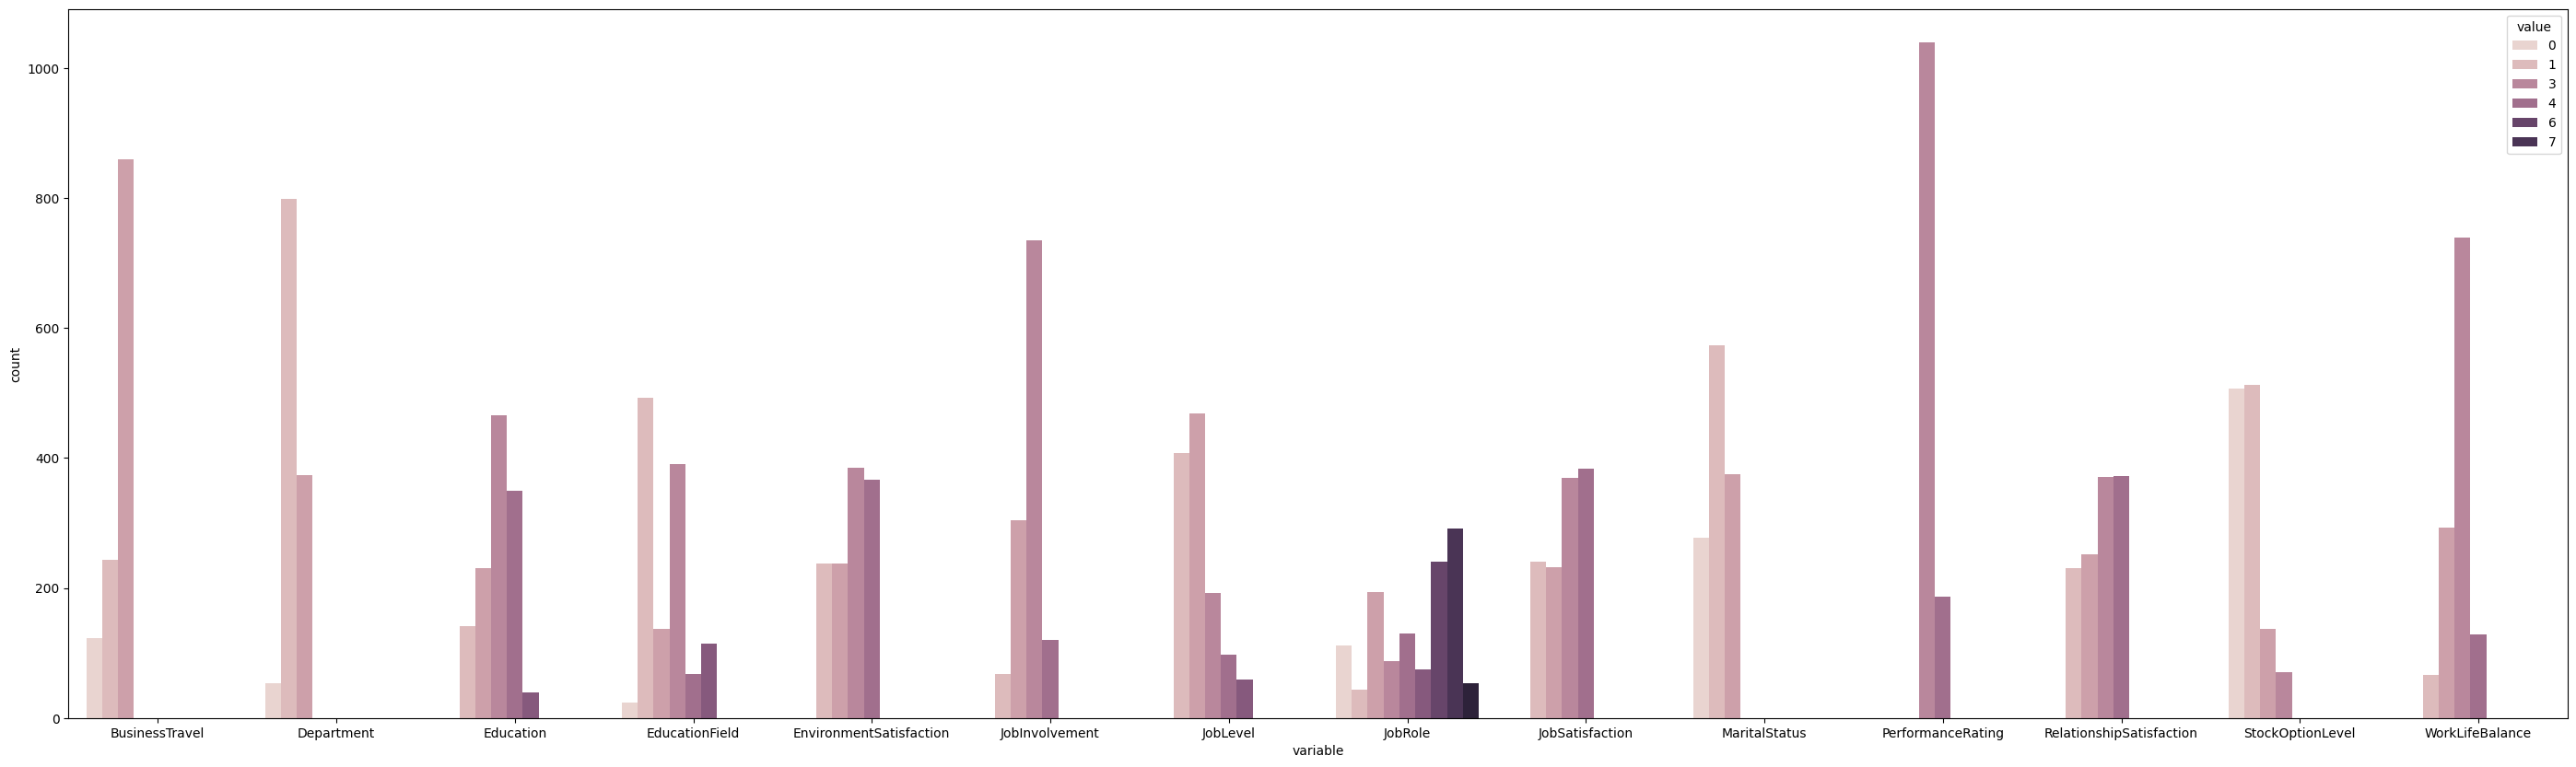

In [71]:
categorical_features = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
plt.figure(figsize=(35,10))
df_categorical = numerical_dataset.loc[:, categorical_features]
sns.countplot(x="variable", hue="value", data=pd.melt(df_categorical));

Dal seguente grafico possiamo notare che genericamente le varie categorie sono abbastanza bilanciate, tranne per 4 categorie in particolare:
- Buisness Travel, dove si può notare che molti dipendenti viaggiano per lavoro
- Departement, da dove si deduce che la maggior parte dei dipendenti lavora nel Research and Developement
- Job Involvement, la maggioranza dei dipendenti analizzati sembra svolgere ruoli di spessore all'interno dell'azienda

L'ultima feature che ci rimane da analizzare è l'Age per la quale realizzeremo un grafico a parte.

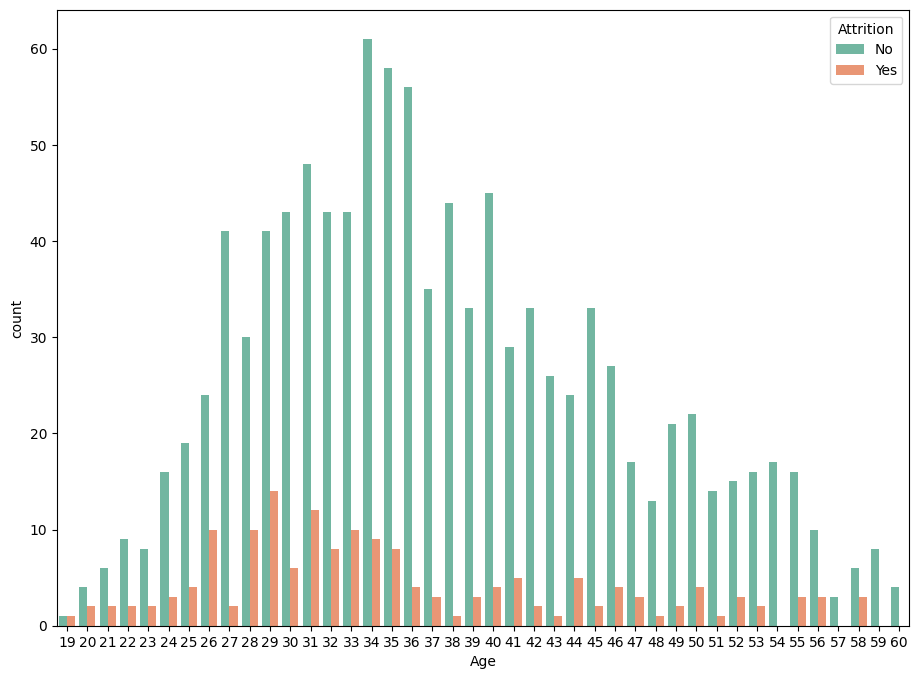

In [72]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='Age', hue='Attrition', data=numerical_dataset, palette="Set2");

Nel grafico sottostante volevamo analizzare il rapporto tra età (Age) e abbandono del lavoro (Attrition).

In genere, ci si aspetterebbe che con l'aumentare dell'età aumenti anche la probabilità di lasciare il lavoro o di essere licenziati.

Tuttavia, i dati non confermano pienamente questa ipotesi: l'età sembra influire poco sui tassi di abbandono, tranne che per i dipendenti di 55 anni e oltre.

In questo caso specifico, la percentuale di abbandoni appare più alta, ma ciò potrebbe essere dovuto alla scarsità di campioni in questa fascia d'età, dove anche pochi licenziamenti incidono significativamente sulla percentuale complessiva.

# Analisi delle Categorie rispetto al Target

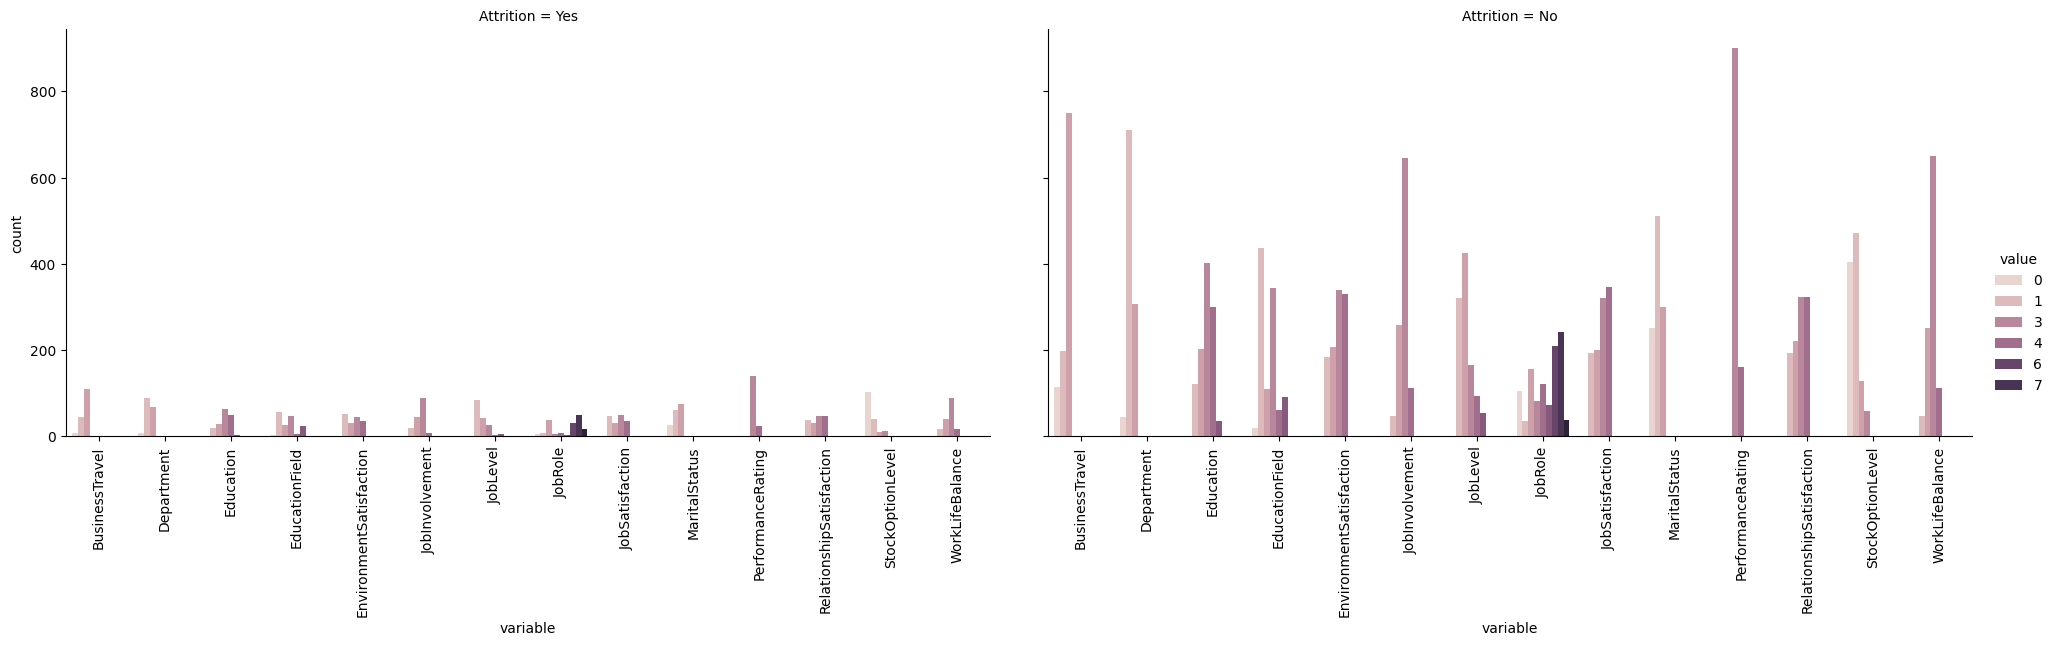

In [73]:
df_long = pd.melt(numerical_dataset, id_vars=['Attrition'], value_vars=categorical_features)

g = sns.catplot(x="variable", hue="value", col="Attrition", data=df_long, kind="count", height=5, aspect=2)

g.axes[0, 0].tick_params(axis='x', labelrotation=90)
g.axes[0, 1].tick_params(axis='x', labelrotation=90)

plt.show()

### Osservazioni:

1. **BusinessTravel**:
   - I dipendenti che viaggiano raramente per lavoro (categoria 0) sembrano avere una maggiore tendenza a rimanere nell'azienda rispetto a quelli che viaggiano frequentemente. Tuttavia, la relazione non è così marcata tra i dipendenti che lasciano l'azienda.

2. **Department**:
   - Il dipartimento in cui un dipendente lavora sembra influenzare la sua decisione di lasciare o meno. Ad esempio, vi è una differenza significativa tra i dipartimenti, con una maggiore concentrazione di abbandoni in alcuni dipartimenti rispetto ad altri.

3. **EnvironmentSatisfaction**:
   - Una bassa soddisfazione ambientale (categorie più chiare) sembra essere associata a un tasso più alto di abbandono, mentre una soddisfazione ambientale più alta (categorie più scure) corrisponde a un tasso di abbandono inferiore.

4. **JobInvolvement**:
   - Anche il coinvolgimento nel lavoro sembra influenzare l'attrition, con i dipendenti meno coinvolti (categorie più chiare) che hanno maggiori probabilità di lasciare.

5. **JobLevel**:
   - I livelli di lavoro più alti (categorie più scure) sembrano avere una minore incidenza di abbandono, mentre i livelli più bassi sono più rappresentati tra chi lascia.

6. **JobSatisfaction**:
   - Simile alla soddisfazione ambientale, una maggiore soddisfazione lavorativa è associata a un minor tasso di abbandono.

7. **MaritalStatus**:
    - Lo stato civile sembra avere un impatto sull'attrition, con alcune categorie più rappresentate tra chi lascia.

8. **RelationshipSatisfaction**:
    - Anche la soddisfazione nelle relazioni lavorative sembra avere un effetto, con una bassa soddisfazione correlata a un maggiore abbandono.

9. **StockOptionLevel**:
    - I livelli di opzioni azionarie più alti sembrano essere associati a una minore probabilità di abbandono.

10. **WorkLifeBalance**:
    - Un migliore equilibrio tra lavoro e vita privata (categorie più scure) sembra ridurre la probabilità di abbandono.


In conclusione, l'analisi suggerisce che alcune variabili categoriche possono avere un impatto significativo sull'Attrition.

La tendenza generale mostra che una maggiore soddisfazione lavorativa e ambientale, un equilibrio migliore tra vita e lavoro, e un coinvolgimento lavorativo più elevato sono associati a una minore probabilità di abbandono.

# Matrice di Correlazione

<Axes: >

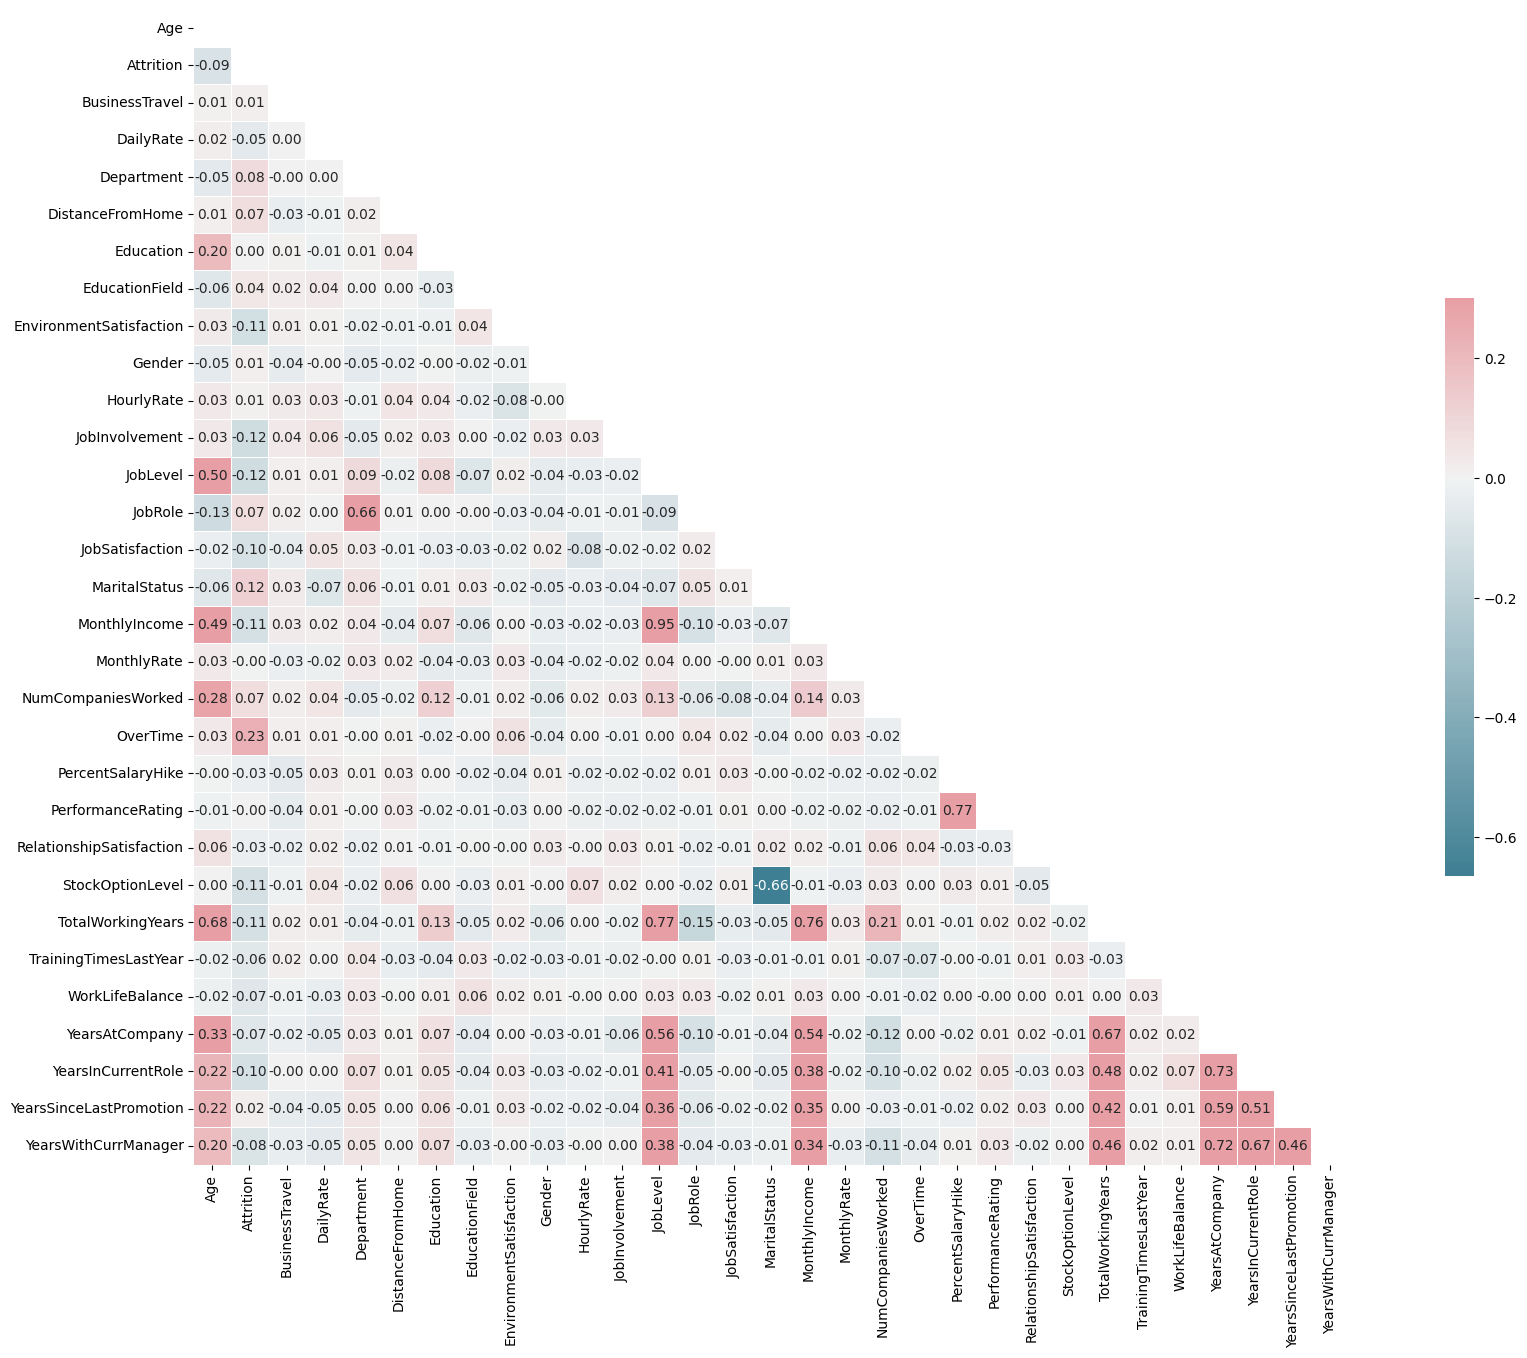

In [74]:
numerical_dataset['Attrition'] = LabelEncoder().fit_transform(numerical_dataset['Attrition'])

correlation_matrix = numerical_dataset.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')

### Osservazioni principali:

1. **Attrition**:
   - La correlazione negativa più forte con **Attrition** è con **Age** (-0,09) e **JobLevel** (-0,16), suggerendo che i dipendenti più giovani e quelli con un livello di lavoro inferiore tendono a lasciare più frequentemente l'azienda.
   - **StockOptionLevel** mostra una correlazione negativa di -0,11 con **Attrition**, indicando che i dipendenti con più opzioni azionarie tendono a rimanere nell'azienda.
   - **YearsWithCurrManager** e **YearsSinceLastPromotion** hanno una correlazione negativa più evidente con **Attrition** (-0,16 e -0,14 rispettivamente), suggerendo che la durata del rapporto con l'attuale manager e il tempo trascorso dall'ultima promozione influenzano la decisione di lasciare.

2. **Age**:
   - È negativamente correlato con **Attrition** (-0,09), come già menzionato.
   - Mostra una correlazione positiva con **JobLevel** (0,50) e **TotalWorkingYears** (0,77), il che è logico, poiché l'età tende ad aumentare con gli anni di esperienza lavorativa e il livello di lavoro.
   - C'è anche una correlazione positiva con **YearsInCurrentRole** (0,52) e **YearsWithCurrManager** (0,50), indicando che i dipendenti più anziani tendono a rimanere più a lungo nello stesso ruolo e con lo stesso manager.

3. **JobLevel**:
   - Fortemente correlato con **TotalWorkingYears** (0,77), indicando che i dipendenti con più anni di esperienza tendono ad avere livelli di lavoro più elevati.
   - Correlazione positiva anche con **MonthlyIncome** (0,95), che indica che i livelli di lavoro più alti sono associati a salari più alti.

4. **TotalWorkingYears**:
   - Come previsto, c'è una forte correlazione con **YearsAtCompany** (0,64), **YearsInCurrentRole** (0,52) e **YearsWithCurrManager** (0,46), suggerendo che chi ha più anni di esperienza tende a rimanere più a lungo in un'azienda e nello stesso ruolo.

5. **YearsAtCompany**:
   - Fortemente correlato con **YearsInCurrentRole** (0,76) e **YearsSinceLastPromotion** (0,51), indicando che chi rimane in un'azienda per lungo tempo tende anche a rimanere nello stesso ruolo per periodi prolungati.

6. **PerformanceRating**:
   - Mostra una correlazione positiva debole ma interessante con **PercentSalaryHike** (0,77), suggerendo che i dipendenti con un aumento di stipendio maggiore tendono ad avere valutazioni di performance più elevate.

Dalla matrice di correlazione si può osservare che alcune variabili, come **JobLevel**, **TotalWorkingYears**, **YearsAtCompany**, e **StockOptionLevel**, mostrano correlazioni significative con la variabile target **Attrition**.

Queste correlazioni suggeriscono che i dipendenti con più esperienza, che ricoprono ruoli più alti e che ricevono opzioni azionarie hanno meno probabilità di lasciare l'azienda.

Al contrario, i dipendenti più giovani e con meno anni nella stessa azienda o ruolo mostrano una tendenza maggiore all'abbandono.

L'analisi di queste correlazioni può aiutare a identificare i fattori critici che influenzano la retention dei dipendenti e a formulare strategie per ridurre il tasso di abbandono.

# Aggiunta di Feature

Abbiamo deciso di aggiungere una nuova feature al nostro dataset chiamata "Salary Delta".

L'obiettivo di questa feature è analizzare le differenze salariali tra dipendenti con lo stesso numero di anni di lavoro all'interno dell'azienda, per evidenziare eventuali disparità salariali.

In questo modo, potremo identificare se esistono ingiustizie o squilibri retributivi tra i dipendenti con pari esperienza.

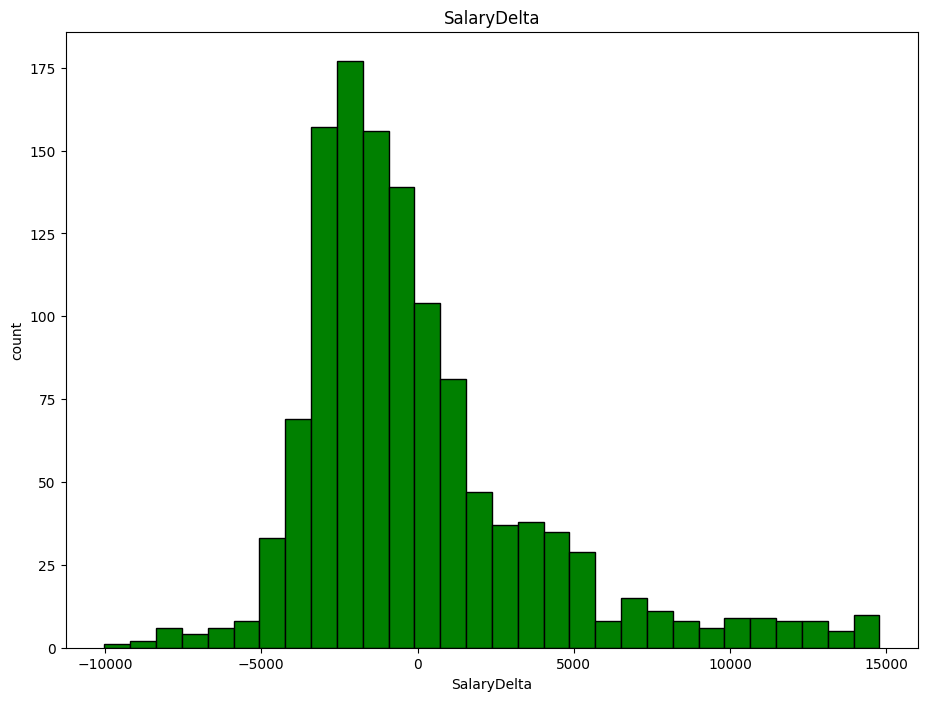

In [75]:
mean_salary = numerical_dataset.groupby('YearsAtCompany')['MonthlyIncome'].mean()
numerical_dataset['MeanSalary'] = numerical_dataset['YearsAtCompany'].map(mean_salary)
numerical_dataset['SalaryDelta'] = numerical_dataset['MonthlyIncome'] - numerical_dataset['MeanSalary']
numerical_dataset.drop('MeanSalary', axis=1, inplace=True)

plt.title('SalaryDelta')
plt.hist(numerical_dataset['SalaryDelta'], label='SalaryDelta', color='green', edgecolor='black',bins=30)
plt.ylabel('count')
plt.xlabel('SalaryDelta')
plt.show()

<Axes: >

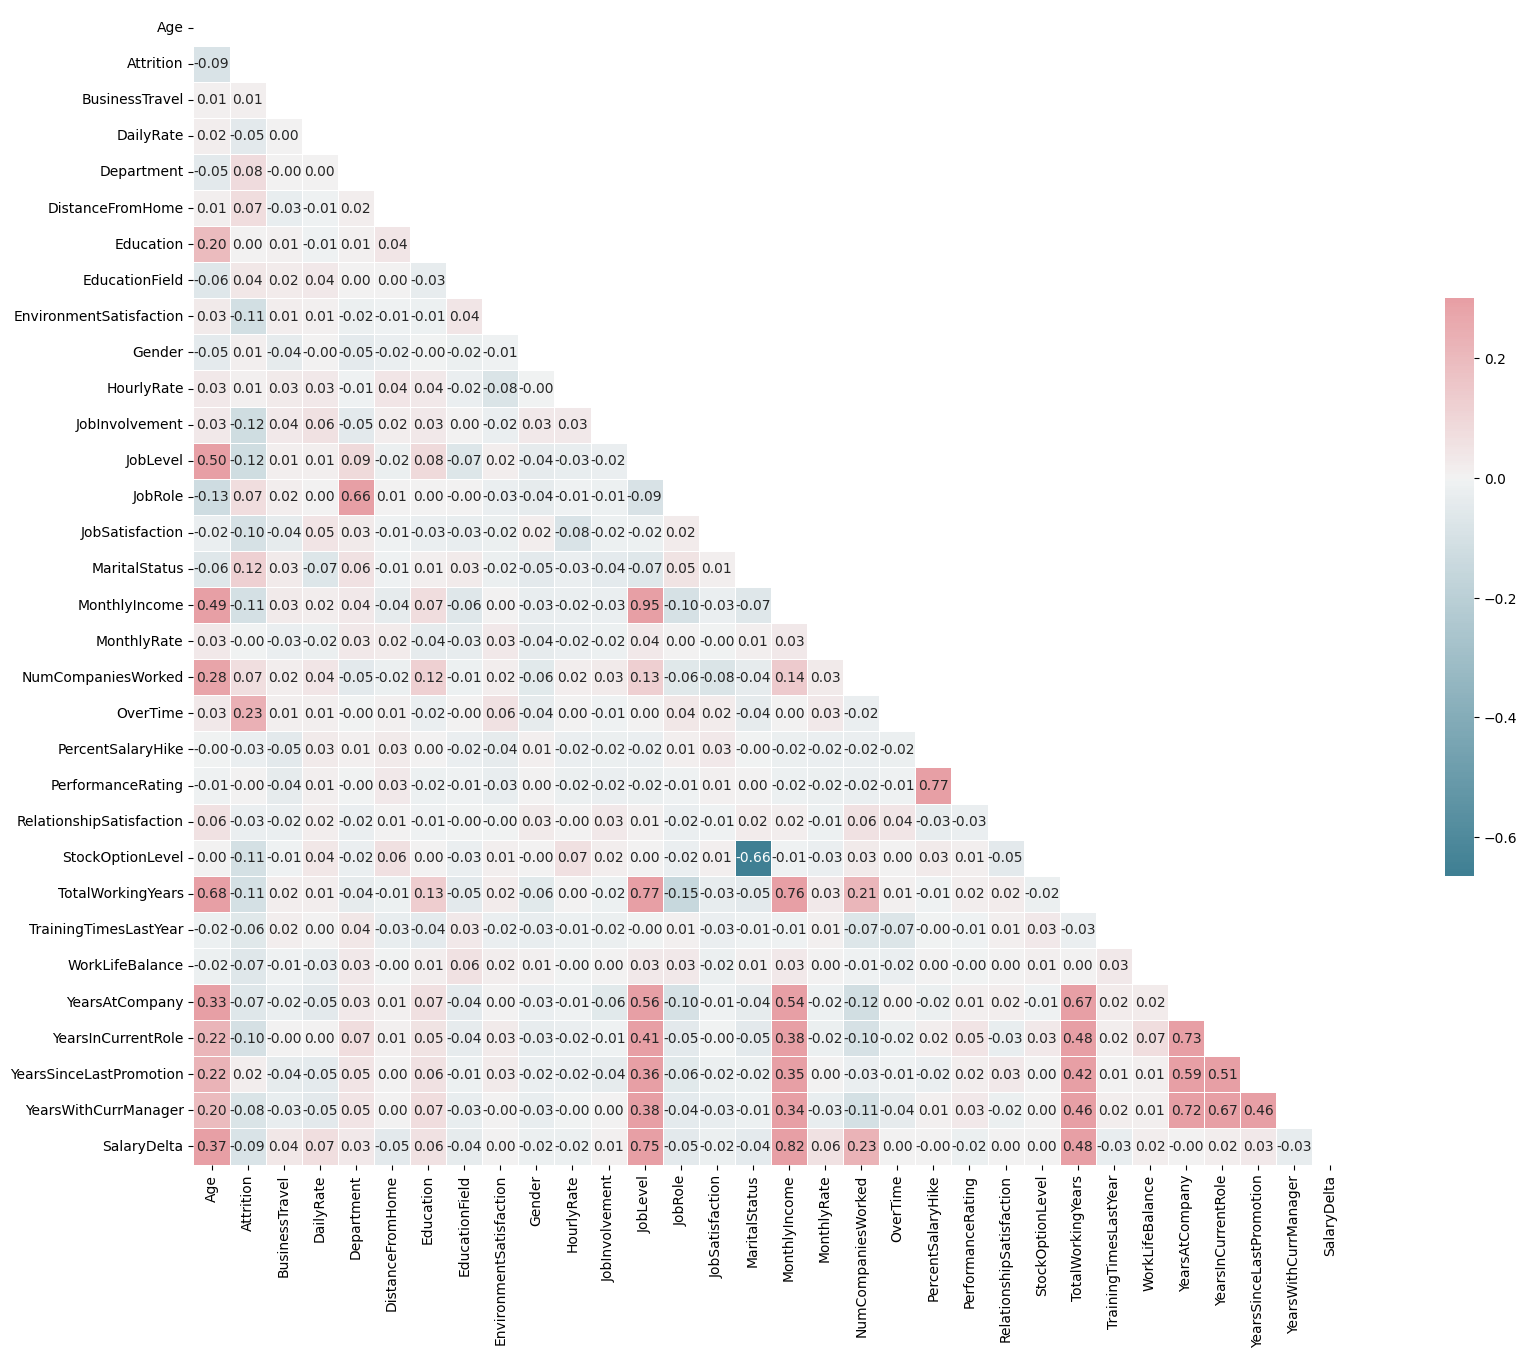

In [76]:
correlation_matrix = numerical_dataset.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True, square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')

Dalla nuova matrice si può notare come il Delta dei Salari risulta, come immaginabile, strettamente legato all'Età e al JobLevel, ma anche in qualche modo legato al numero di compagnie con dui il dipendente abbia lavorato.

A quanto pare però risulta non molto influente nei riguardi dell'Attrition.

# Analisi della Variabile Target

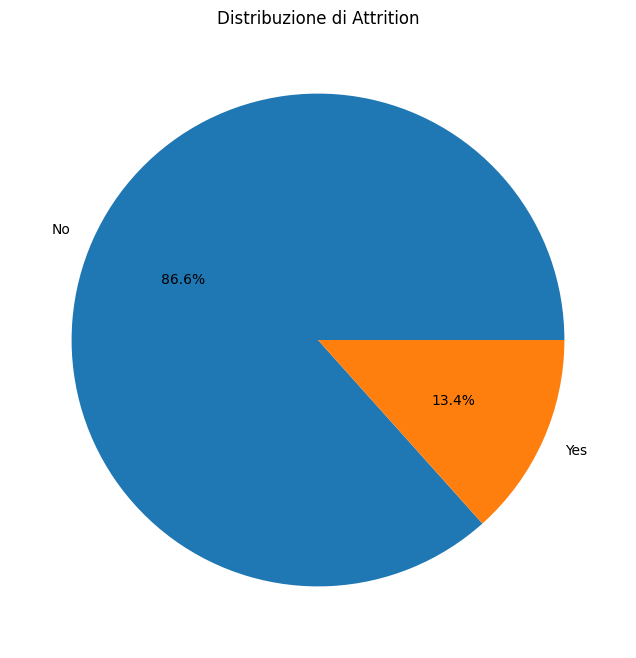

In [77]:
# Distribuzione della variabile target (Attrition)
dataset['Attrition'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuzione di Attrition')
plt.ylabel('')
plt.show()

Dal grafico possiamo notare che il problema in esame risulta non essere bilanciato ed è quindi necessario effettuare delle procedure di bilanciamento.

Come tecnica di bilanciamento anrdemo a utilizzare un oversampling dei dati con Attrition positiva.

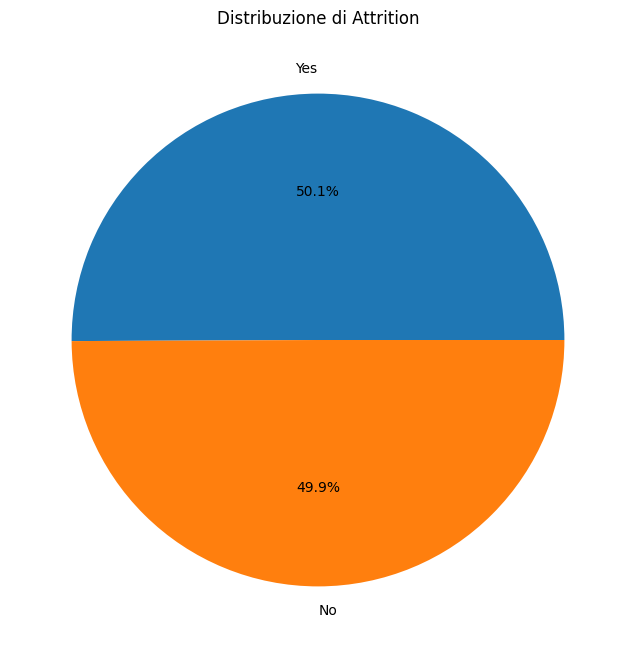

In [78]:
# Separazione delle classi
df_no = numerical_dataset[numerical_dataset['Attrition'] == 0].copy()
df_yes = numerical_dataset[numerical_dataset['Attrition'] == 1].copy()

# Oversampling della classe "Yes"
df_yes_oversampled = resample(df_yes, replace=True, n_samples=len(df_no), random_state=42)

# Combina il dataset oversampled con la classe "No"
df_oversampled = pd.concat([df_no, df_yes_oversampled])

X = df_oversampled.copy().drop('Attrition', axis=1)
y = df_oversampled['Attrition'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,             # dati da suddividere
    test_size=1/3,    # proporzione: 2/3 training, 1/3 validation
    random_state=42   # seed per la riproducibilità
)

y_train.copy().replace({0: 'No', 1: 'Yes'}).value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuzione di Attrition')
plt.ylabel('')
plt.show()

In [79]:
from statsmodels.stats.proportion import proportion_confint

def confidence_interval(instance, acc, confidence):
    return proportion_confint(instance * acc, instance, 1-confidence/100, method='wilson')

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Perceptron

In [80]:
# Perceptron with standard scaler
std_perceptron = Pipeline([
    ('std', StandardScaler()),
    ('perceptron', Perceptron(max_iter=1000, tol=1e-3, early_stopping=True, alpha=0.0001, n_jobs=-1))
])

std_perceptron.fit(X_train, y_train)

print('Accuracy on train {:.2f}%'.format(std_perceptron.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(std_perceptron.score(X_test, y_test)*100))

Accuracy on train 66.24%
Accuracy on val 69.35%


In [126]:
std_perceptron = Pipeline([
    ('std', StandardScaler()),
    ('perceptron', Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5))
])

parameters = {
    'std': [None, StandardScaler()],
    'perceptron__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__alpha': [0.0001, 0.001, 0.01, 1],
    'perceptron__tol': [1e-9, 1e-6, 1e-3, 1, 1e3, 1e6],
}

perceptron_cv = GridSearchCV(estimator=std_perceptron, param_grid=parameters, cv=5, n_jobs=-1, scoring='f1', verbose=4)
perceptron_cv.fit(X_train, y_train)
print('GridSearch on Perceptron finish')
print('Best parameters found: ', perceptron_cv.best_params_)
print('Best accuracy score: ', perceptron_cv.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
GridSearch on Perceptron finish
Best parameters found:  {'perceptron__alpha': 0.0001, 'perceptron__penalty': 'l1', 'perceptron__tol': 1e-09, 'std': StandardScaler()}
Best accuracy score:  0.6889999263050197


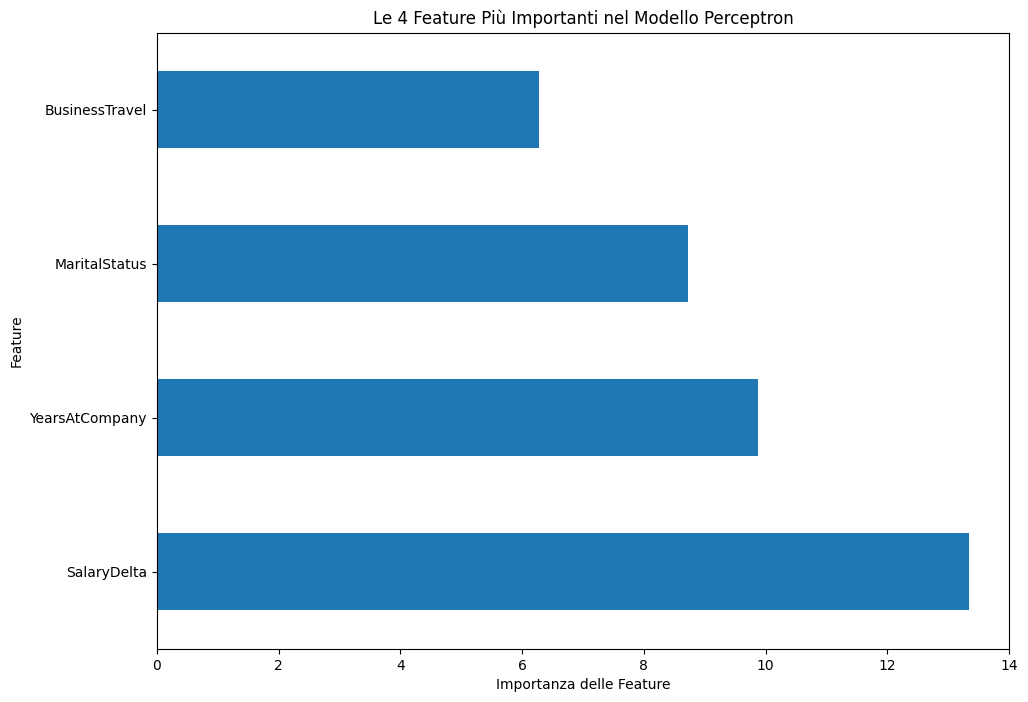

In [82]:
# Assumendo che il miglior modello sia stato trovato e che il Perceptron sia l'ultimo passo
best_perceptron = perceptron_cv.best_estimator_

# Estrazione delle importanze dei pesi delle feature
pc_imp = pd.Series(perceptron_cv.best_estimator_[1].coef_[0], index=X_train.columns)
pc_imp.nlargest(4).plot(kind='barh')

plt.xlabel("Importanza delle Feature")
plt.ylabel("Feature")
plt.title("Le 4 Feature Più Importanti nel Modello Perceptron")
plt.show()

Possiamo osservare che a seguito della penalizzazione **l1**, trovata mediate grid search, le features che sono rilevanti in questo modello sono il Delta del Salario, gli Anni spesi nella Compagnia, lo Stato Matrimoniale e se il dipendente Viaggia spesso.


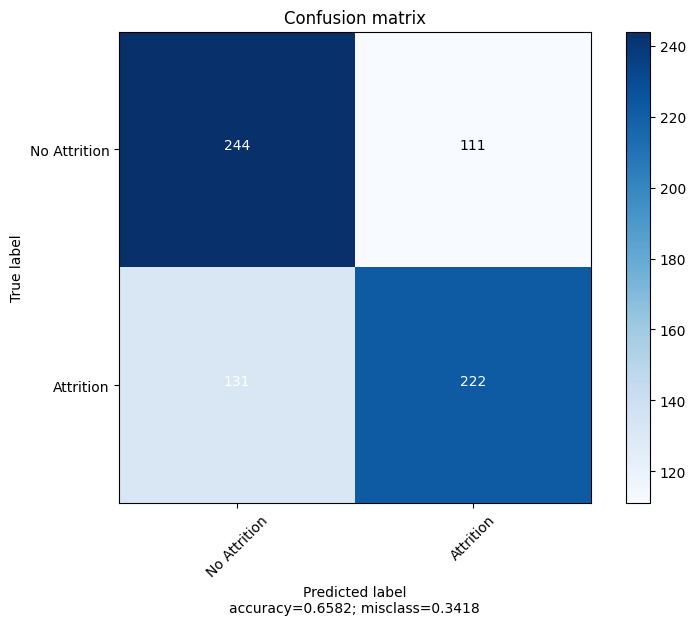

In [83]:
y_pred = perceptron_cv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [84]:
pred = perceptron_cv.predict(X_test)
print(classification_report(y_test, pred))
perc_mse = mean_squared_error(y_test, perceptron_cv.predict(X_test))
print('MSE: {}'.format(perc_mse))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67       355
           1       0.67      0.63      0.65       353

    accuracy                           0.66       708
   macro avg       0.66      0.66      0.66       708
weighted avg       0.66      0.66      0.66       708

MSE: 0.3418079096045198


# Polynomial Perceptron

In [85]:
poly_perceptron = Pipeline([
    ('std', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3)),
    ('perceptron', Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5))
])

parameters = {
    'std': [None, StandardScaler()],
    'perceptron__penalty': ['l1', 'l2'],
    'perceptron__alpha': [0.0001, 0.001, 0.01],
    'perceptron__tol': [1e-9, 1e-6, 1e-3, 1],
}

poly_perceptron_cv = GridSearchCV(poly_perceptron, parameters, cv=5, n_jobs=-1, return_train_score=True, scoring='f1')
poly_perceptron_cv.fit(X_train, y_train)
print('GridSearch on Perceptron finish')

print('Best parameters: ', poly_perceptron_cv.best_params_)
print('Best score: {:.4f}%'.format(round(poly_perceptron_cv.best_score_ * 100, 4)))

confidence = 95
lower, upper = confidence_interval(len(X_test), poly_perceptron_cv.score(X_test, y_test), confidence)
print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

GridSearch on Perceptron finish
Best parameters:  {'perceptron__alpha': 0.0001, 'perceptron__penalty': 'l1', 'perceptron__tol': 1e-09, 'std': StandardScaler()}
Best score: 91.4255%
Interval with confidence 95%: 
Pmin = 90.9744%
Pmax = 94.7308%


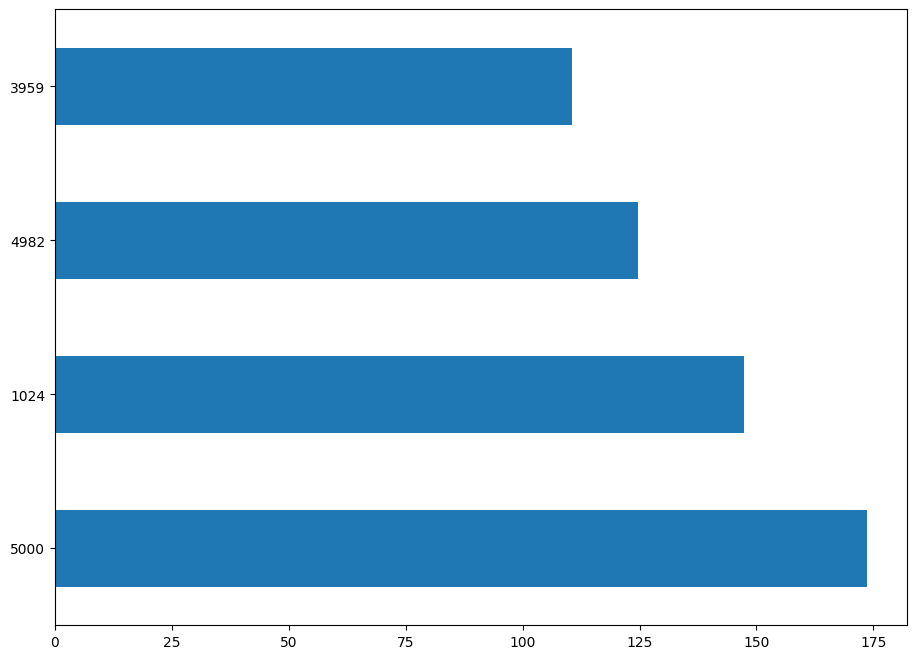

In [86]:
# Assumendo che il miglior modello sia stato trovato e che il Perceptron sia l'ultimo passo
best_perceptron = poly_perceptron_cv.best_estimator_

# Estrazione delle importanze dei pesi delle feature
pc_imp = pd.Series(poly_perceptron_cv.best_estimator_[2].coef_[0])
pc_imp.nlargest(4).plot(kind='barh')
plt.show()

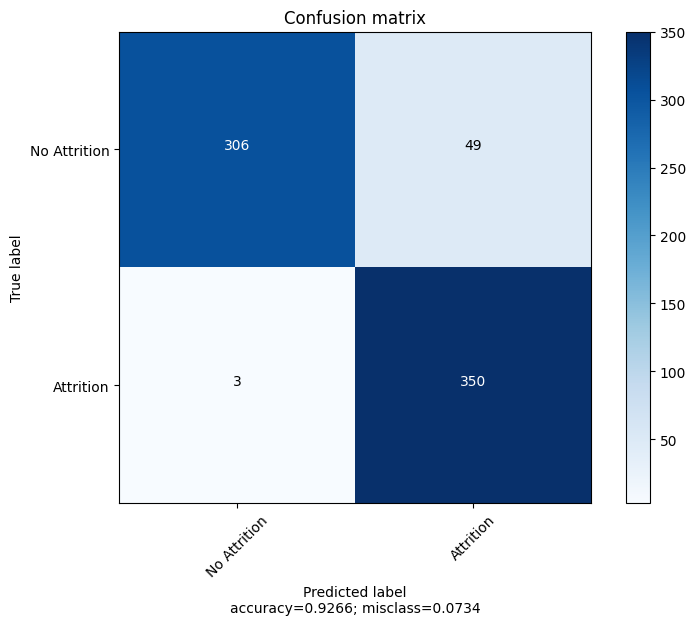

In [87]:
y_pred = poly_perceptron_cv.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [88]:
pred = poly_perceptron_cv.predict(X_test)
print(classification_report(y_test, pred))
poly_mse = mean_squared_error(y_test, poly_perceptron_cv.predict(X_test))
print('MSE: {}'.format(poly_mse))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       355
           1       0.88      0.99      0.93       353

    accuracy                           0.93       708
   macro avg       0.93      0.93      0.93       708
weighted avg       0.93      0.93      0.93       708

MSE: 0.07344632768361582


# Logic Regression

In [89]:
std_lr = Pipeline([
    ('std', StandardScaler()),
    ('lr', LogisticRegression(dual=False))
])

parameters = {
    'lr__penalty': ['l1'],
    'lr__tol': [1e-9, 1e-6, 1e-3, 1e-2, 1e-1, 1],
    'lr__C': [1, 0.8, 0.3],
    'lr__solver': ['liblinear']
}

lr_gs = GridSearchCV(std_lr, parameters, cv=5, n_jobs=-1, return_train_score=True, scoring='f1')
lr_gs.fit(X_train, y_train)
print("Grid search finish")

print('Best parameters:', lr_gs.best_params_)
print('Best train score: {:.4f}%\nBest validation score: {:.4f}%'.format(round(lr_gs.best_score_ * 100, 4), round(lr_gs.score(X_train, y_train)*100, 4)))

Grid search finish
Best parameters: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'lr__tol': 1e-09}
Best train score: 75.1050%
Best validation score: 76.7746%


<Axes: >

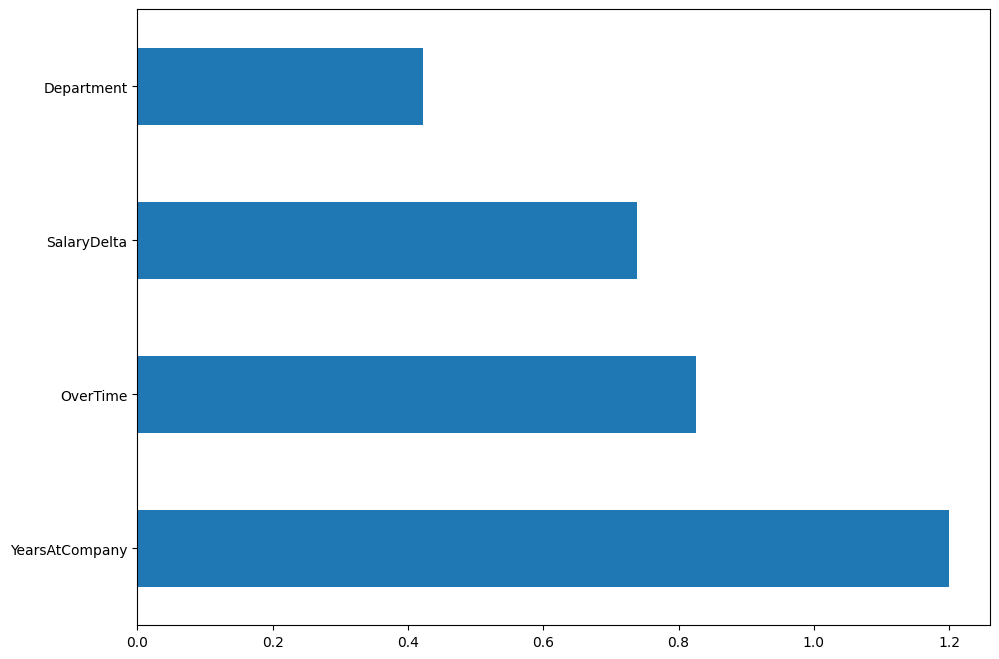

In [90]:
lr_imp = pd.Series(lr_gs.best_estimator_[1].coef_[0], index=X_train.columns)
lr_imp.nlargest(4).plot(kind='barh')

La regressione logistica ha identificato come caratteristiche rilevanti per la previsione del modello gli Anni presso la Compagnia, il fare Straordinari, il Delta del Salario e il Dipartimento.

Anche in questo caso, tali caratteristiche risultano coerenti, poiché, come emerso durante l'analisi esplorativa iniziale.

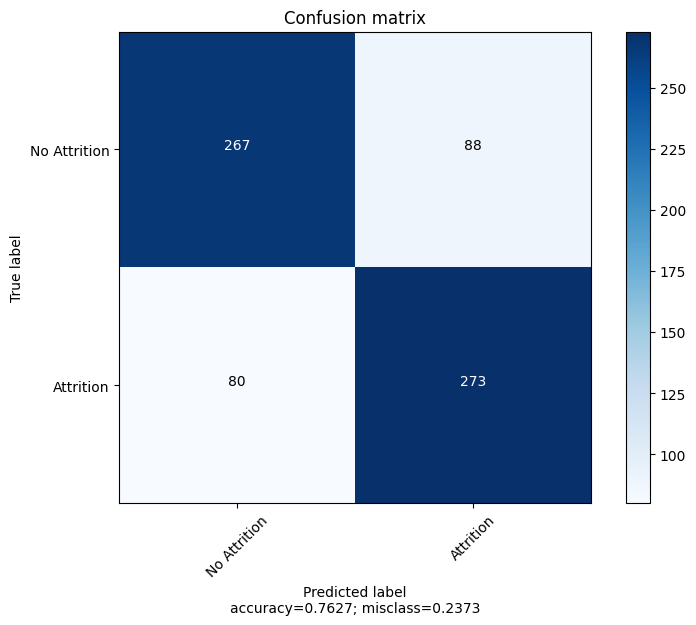

In [91]:
y_pred = lr_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [92]:
pred = lr_gs.predict(X_test)
print(classification_report(y_test, pred))
lr_mse = mean_squared_error(y_test, lr_gs.predict(X_test))
print('MSE: {}'.format(lr_mse))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       355
           1       0.76      0.77      0.76       353

    accuracy                           0.76       708
   macro avg       0.76      0.76      0.76       708
weighted avg       0.76      0.76      0.76       708

MSE: 0.23728813559322035


# SVM

In [93]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_svm = Pipeline([
    ('std', StandardScaler()),
    ('svm', SVC())
])

parameters = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1],
}

svm_gs = GridSearchCV(std_svm, parameters, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
svm_gs.fit(X_train, y_train)
print('Finish SVM Grid Search')
print('Best parameters:', svm_gs.best_params_)
print('Best train score: {:.4f}%\nBest validation score: {:.4f}%'.format(round(svm_gs.best_score_ * 100, 4), round(svm_gs.score(X_test, y_test)*100, 4)))
confidence = 95
lower, upper = confidence_interval(len(X_test), svm_gs.score(X_test, y_test), confidence)
print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Finish SVM Grid Search
Best parameters: {'svm__C': 1, 'svm__kernel': 'rbf'}
Best train score: 87.3356%
Best validation score: 91.0615%
Interval with confidence 95%: 
Pmin = 88.7323%
Pmax = 92.9474%


<Axes: >

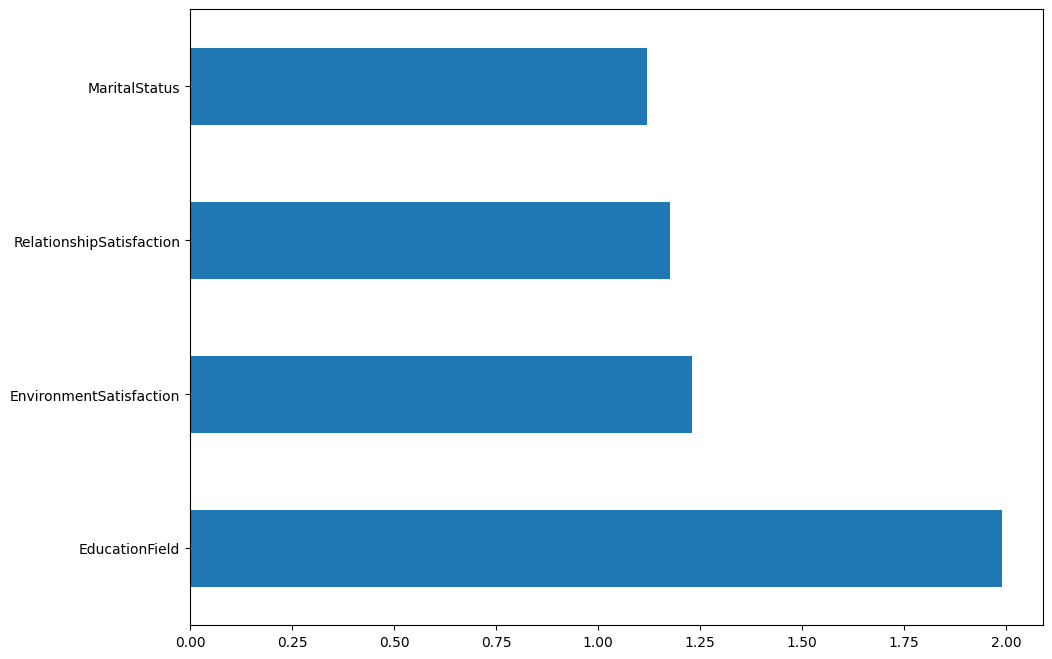

In [94]:
svm_imp = pd.Series(svm_gs.best_estimator_[1].support_vectors_[0], index=X_train.columns)
svm_imp.nlargest(4).plot(kind='barh')

Il modello SVM ha evidenziato come caratteristiche più rilevanti il Campo di Specializzazione, la Soddisfazione, l'altezza e l'età. È ben noto che il fumo ha un impatto negativo sul sistema cardiovascolare, aumentando il rischio di problemi cardiaci. Tuttavia, l'inclusione del sesso e dell'altezza tra le caratteristiche rilevanti per determinare il rischio cardiovascolare può sembrare discutibile, poiché non esistono evidenze mediche solide che dimostrino una correlazione diretta tra questi fattori e i problemi cardiovascolari. Nonostante ciò, il modello si è dimostrato accurato e preciso nelle sue previsioni.

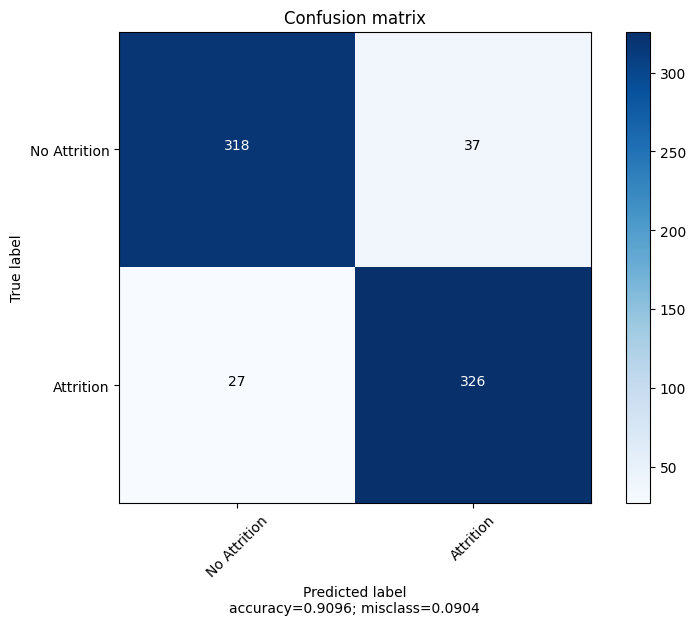

In [95]:
y_pred = svm_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [96]:
pred = svm_gs.predict(X_test)
print(classification_report(y_test, pred))
svm_mse = mean_squared_error(y_test, svm_gs.predict(X_test))
print('MSE: {}'.format(svm_mse))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       355
           1       0.90      0.92      0.91       353

    accuracy                           0.91       708
   macro avg       0.91      0.91      0.91       708
weighted avg       0.91      0.91      0.91       708

MSE: 0.0903954802259887


# Random Forest

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = Pipeline([
    ('std', StandardScaler()),
    ('rfc', RandomForestClassifier(n_jobs=-1, random_state=3))
])

parameters = {
    'rfc__n_estimators': [100, 200, 300],
    'rfc__max_depth': [2, 4, 6, 8, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__min_samples_split': [2, 5, 10],
}


rfc_gs = GridSearchCV(rfc, parameters, cv=5, n_jobs=-1, return_train_score=True, scoring='f1')
rfc_gs.fit(X_train, y_train)

print('Random Forest GridSearch finish')
print('Best parameters:',rfc_gs.best_params_)
print('Best train score: {:.4f}%\nBest validation score: {:.4f}%'.format(round(rfc_gs.best_score_ * 100, 4), round(rfc_gs.score(X_test, y_test)*100, 4)))
confidence = 95
lower, upper = confidence_interval(len(X_test), rfc_gs.score(X_test, y_test), confidence)
print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Random Forest GridSearch finish
Best parameters: {'rfc__max_depth': 10, 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200}
Best train score: 96.6603%
Best validation score: 97.0629%
Interval with confidence 95%: 
Pmin = 95.5429%
Pmax = 98.0750%


<Axes: >

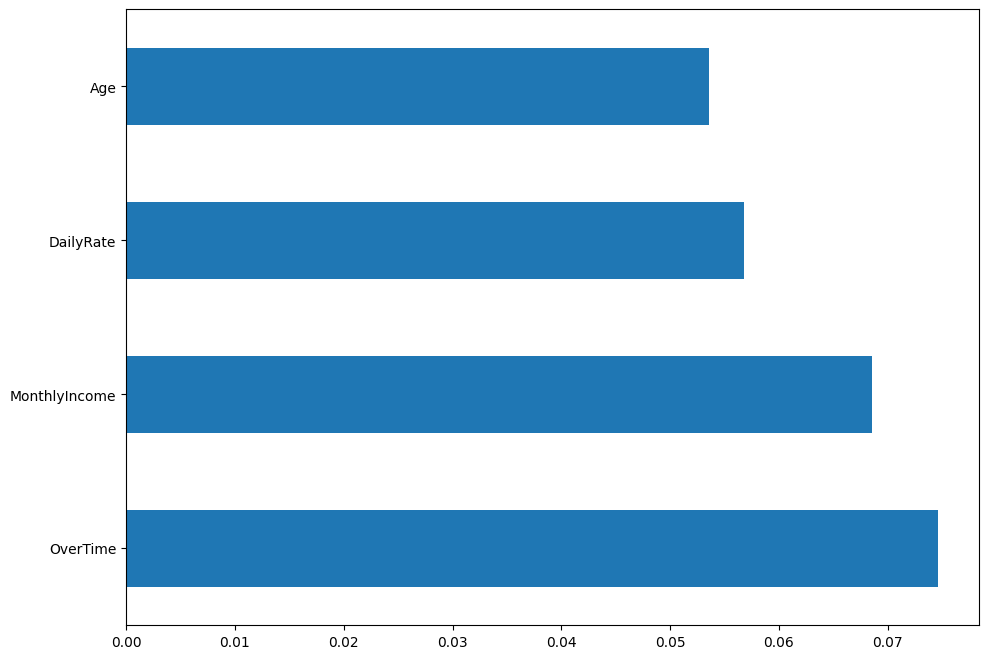

In [98]:
rfc_imp = pd.Series(rfc_gs.best_estimator_[1].feature_importances_, index=X_train.columns)
rfc_imp.nlargest(4).plot(kind='barh')

Il modello Random Forest ha identificato il fare Straordinari, i Guadagni Mensili, il Rate Giornaliero e l'Età come fattori determinanti per la previsione.

Come nei casi precedenti, queste caratteristiche risultano ragionevoli.

In particolare, sembra che un livello elevato di Straordinari sia una causa di possibili Attriti tra azienda e lavoratore

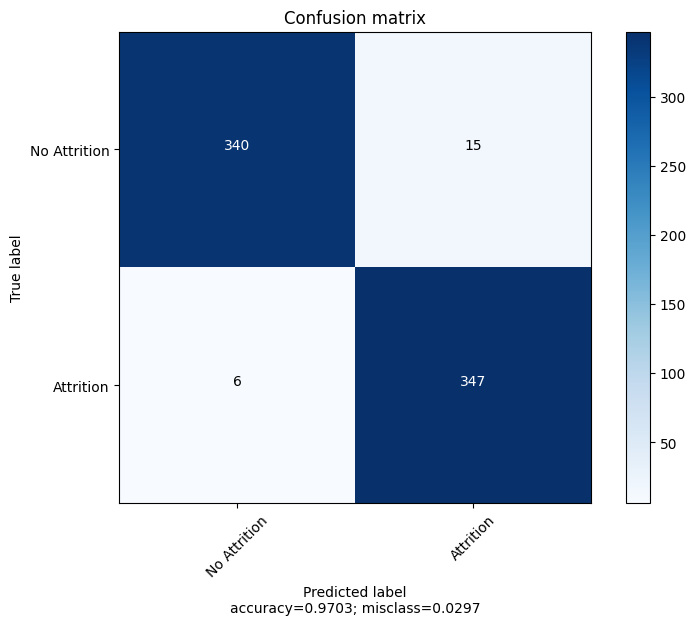

In [99]:
y_pred = rfc_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [100]:
pred = rfc_gs.predict(X_test)
print(classification_report(y_test, pred))
rfc_mse = mean_squared_error(y_test, rfc_gs.predict(X_test))
print('MSE: {}'.format(rfc_mse))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       355
           1       0.96      0.98      0.97       353

    accuracy                           0.97       708
   macro avg       0.97      0.97      0.97       708
weighted avg       0.97      0.97      0.97       708

MSE: 0.029661016949152543


#XGBoost

il modello è applicato al dataset con l'obiettivo di predire la probabilità di attrition (cioè se un dipendente lascerà l'azienda o meno).

In [101]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

xgb_pipeline = Pipeline([
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
])

xgb_params = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

xgb_gs = GridSearchCV(xgb_pipeline, xgb_params, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
xgb_gs.fit(X_train, y_train)

print('Conclusa la ricerca a griglia per XGBoost')
print('Migliori parametri:', xgb_gs.best_params_)
print('Miglior punteggio di addestramento: {:.4f}%'.format(xgb_gs.best_score_ * 100))
print('Miglior punteggio di validazione: {:.4f}%'.format(xgb_gs.score(X_test, y_test) * 100))

confidence = 95
lower, upper = confidence_interval(len(X_test), xgb_gs.score(X_test, y_test), confidence)
print('Intervallo con confidenza {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Conclusa la ricerca a griglia per XGBoost
Migliori parametri: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
Miglior punteggio di addestramento: 94.0659%
Miglior punteggio di validazione: 96.8363%
Intervallo con confidenza 95%: 
Pmin = 95.2732%
Pmax = 97.8940%


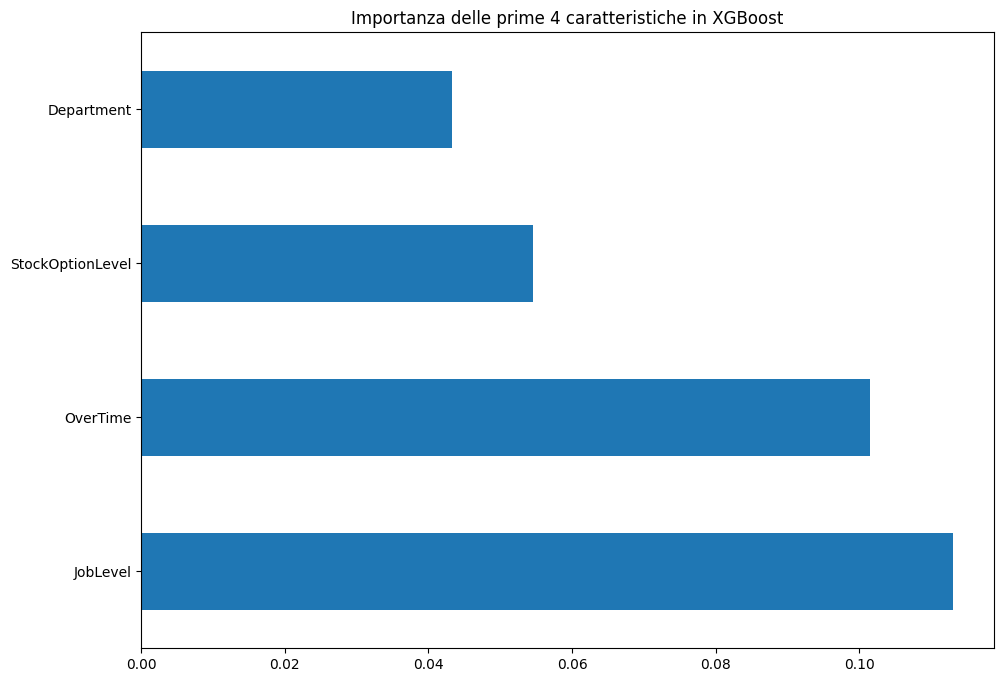

In [102]:
xgb_best = xgb_gs.best_estimator_.named_steps['xgb']
xgb_imp = pd.Series(xgb_best.feature_importances_, index=X_train.columns)
xgb_imp.nlargest(4).plot(kind='barh')
plt.title('Importanza delle prime 4 caratteristiche in XGBoost')
plt.show()

y_pred = xgb_gs.predict(X_test)

XGBoost evidenzia ancora una volta che un lavoro di alto livello e' indice di possibili Attriti, come il fare Straordinari.

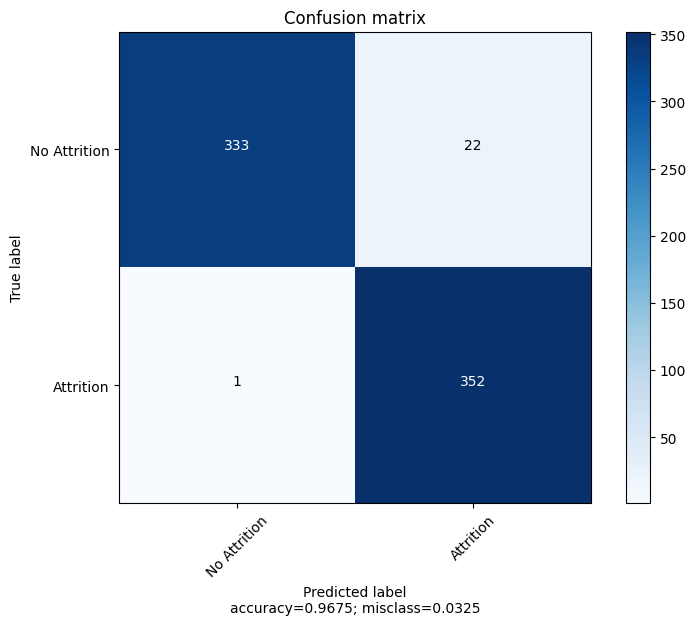

In [103]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [104]:
print(classification_report(y_test, y_pred))
xgb_mse = mean_squared_error(y_test, y_pred)
print('MSE: {}'.format(xgb_mse))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       355
           1       0.94      1.00      0.97       353

    accuracy                           0.97       708
   macro avg       0.97      0.97      0.97       708
weighted avg       0.97      0.97      0.97       708

MSE: 0.03248587570621469


Il modello XGBoost ha ottenuto ottimi risultati con un'accuratezza di validazione del 96.84% e un MSE basso di 0.0325, indicando sia una buona capacità di generalizzazione sia una bassa errore di previsione. I parametri ottimizzati, come una profondità di 5 alberi e un tasso di apprendimento di 0.2, hanno contribuito a un equilibrio tra precisione e complessità. L'intervallo di confidenza stretto per l'accuratezza conferma l'affidabilità dei risultati. Le caratteristiche più importanti, come il dipartimento e le ore straordinarie, riflettono fattori cruciali nell'attrito dei dipendenti, suggerendo che il modello identifica efficacemente i determinanti principali dell'attrito.

# Nested Cross-Validation

La nested cross-validation aiuta a prevenire il sovradattamento degli iperparametri ai dati di training. Questo sovradattamento può accadere quando si eseguono sia l’ottimizzazione dei parametri iper (tramite GridSearchCV, ad esempio) che la valutazione del modello sugli stessi dati.

Poiché si utilizza una valida separazione tra il set di dati usato per la selezione dei parametri iper e quello usato per la valutazione del modello, si ottiene una stima più accurata della capacità del modello di generalizzare a dati non visti.

La nested cross-validation implica due cicli di cross-validation:

* Outer loop (ciclo esterno): Divide i dati in training e test set per valutare il modello.
* Inner loop (ciclo interno): Esegue la cross-validation su ogni fold del ciclo esterno per trovare i migliori parametri iper.


In [105]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
])

xgb_params = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_gs = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_params, cv=inner_cv, n_jobs=-1, scoring='f1')

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(xgb_gs, X, y, cv=outer_cv, scoring='f1', n_jobs=-1)

print('Nested Cross-Validation F1 Score: {:.4f} ± {:.4f}'.format(nested_scores.mean(), nested_scores.std()))

xgb_gs.fit(X_train, y_train)

print('Best parameters:', xgb_gs.best_params_)
print('Best train score from inner CV: {:.4f}%'.format(xgb_gs.best_score_ * 100))

y_pred = xgb_gs.predict(X_test)
test_score = xgb_gs.score(X_test, y_test)
print('Validation score on the test set: {:.4f}%'.format(test_score * 100))

confidence = 95
lower, upper = confidence_interval(len(X_test), test_score, confidence)
print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower * 100, upper * 100))

Nested Cross-Validation F1 Score: 0.9752 ± 0.0075
Best parameters: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
Best train score from inner CV: 93.8116%
Validation score on the test set: 97.2376%
Interval with confidence 95%: 
Pmin = 95.7520%
Pmax = 98.2133%


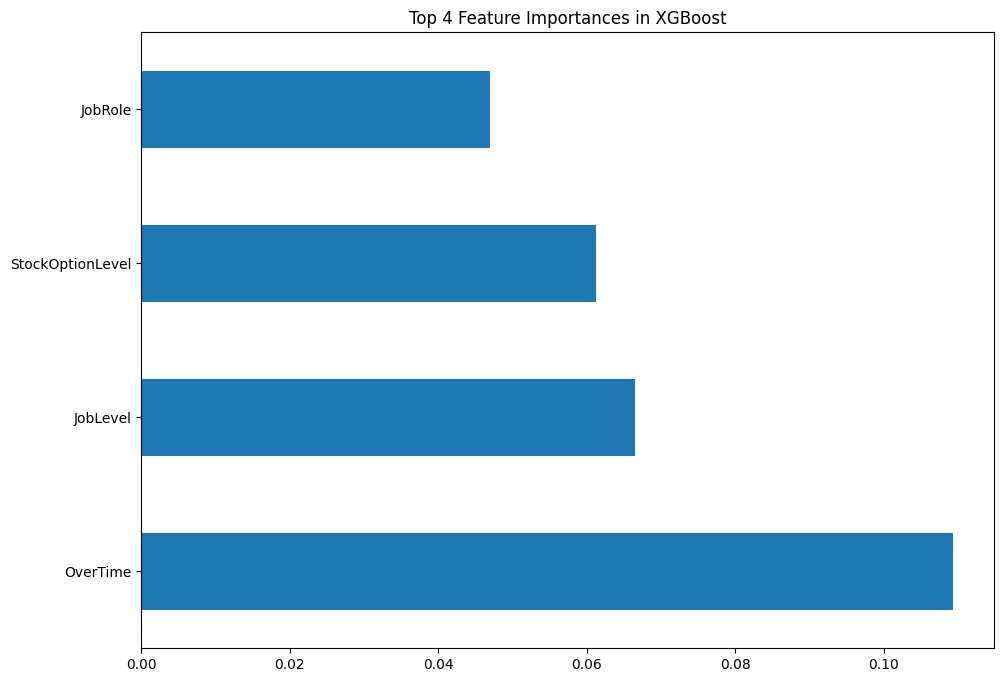

In [106]:
xgb_best = xgb_gs.best_estimator_.named_steps['xgb']
xgb_imp = pd.Series(xgb_best.feature_importances_, index=X_train.columns)
xgb_imp.nlargest(4).plot(kind='barh')
plt.title('Top 4 Feature Importances in XGBoost')
plt.show()

Anche per la Nested Cross-Validation i risultati sono simili ai precedenti.

Il fare Straordinari risulta essere ancora una volta il fattore principale di Attrition, seguito dal Livello di Importanza del proprio Lavoro, il venire pagato in Stock Aziendali e il proprio Ruolo

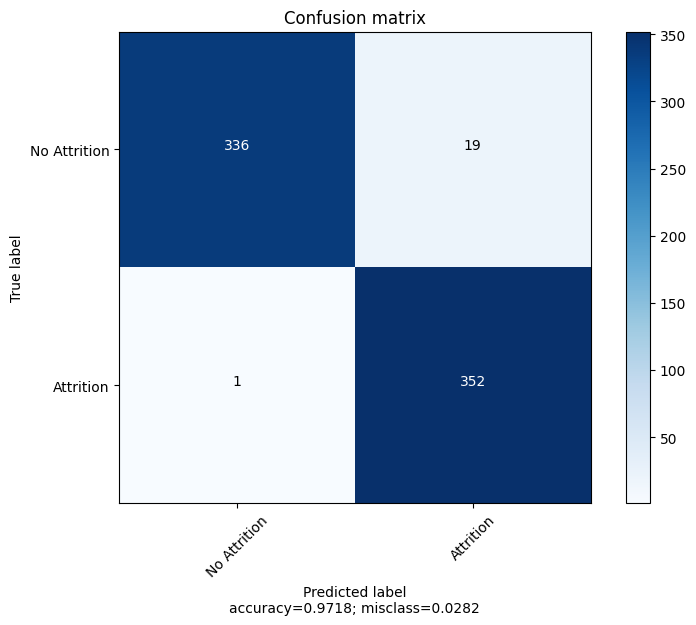

In [107]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [108]:
print(classification_report(y_test, y_pred))
xgb_mse = mean_squared_error(y_test, y_pred)
print('MSE: {}'.format(xgb_mse))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       355
           1       0.95      1.00      0.97       353

    accuracy                           0.97       708
   macro avg       0.97      0.97      0.97       708
weighted avg       0.97      0.97      0.97       708

MSE: 0.02824858757062147


La Nested Cross-Validation ha prodotto un punteggio F1 medio di 0.9752, con una deviazione standard di 0.0075, indicando che il modello offre prestazioni stabili e affidabili su diverse suddivisioni del dataset. I parametri migliori identificati sono una profondità massima degli alberi di 5, un tasso di apprendimento di 0.1, 200 alberi nella foresta, e l'uso completo delle colonne con un campionamento del 80% dei dati per ogni albero.

Questi parametri hanno portato a un punteggio di addestramento del 93.81% nella cross-validation interna e a una valutazione di validazione del 97.24% sul test set. L'intervallo di confidenza al 95% per l'accuratezza varia tra il 95.75% e il 98.21%, suggerendo che il modello è altamente preciso e le sue prestazioni sono robuste.

Le caratteristiche più importanti identificate, jobrole, stockoptionlevel, joblevel, e overtime, evidenziano fattori chiave che influenzano significativamente l'attrito dei dipendenti. Questi risultati suggeriscono che il modello non solo ha ottimizzato bene i suoi iperparametri, ma ha anche identificato le variabili più rilevanti per prevedere l'attrito, migliorando la sua capacità di classificare i dipendenti in base alla loro propensione a lasciare l'azienda.

# Decision Trees

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

dt_pipeline = Pipeline([
    ('std', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state=42))
])

dt_params = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
dt_gs = GridSearchCV(estimator=dt_pipeline, param_grid=dt_params, cv=inner_cv, n_jobs=-1, scoring='f1')

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_scores = cross_val_score(dt_gs, X, y, cv=outer_cv, scoring='f1', n_jobs=-1)

print('Nested Cross-Validation F1 Score: {:.4f} ± {:.4f}'.format(nested_scores.mean(), nested_scores.std()))

dt_gs.fit(X_train, y_train)

print('Best parameters:', dt_gs.best_params_)
print('Best train score from inner CV: {:.4f}%'.format(dt_gs.best_score_ * 100))

y_pred = dt_gs.predict(X_test)
test_score = dt_gs.score(X_test, y_test)
print('Validation score on the test set: {:.4f}%'.format(test_score * 100))

confidence = 95
lower, upper = confidence_interval(len(X_test), test_score, confidence)
print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower * 100, upper * 100))

Nested Cross-Validation F1 Score: 0.9242 ± 0.0130
Best parameters: {'dt__criterion': 'gini', 'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best train score from inner CV: 90.0300%
Validation score on the test set: 93.5829%
Interval with confidence 95%: 
Pmin = 91.5322%
Pmax = 95.1632%


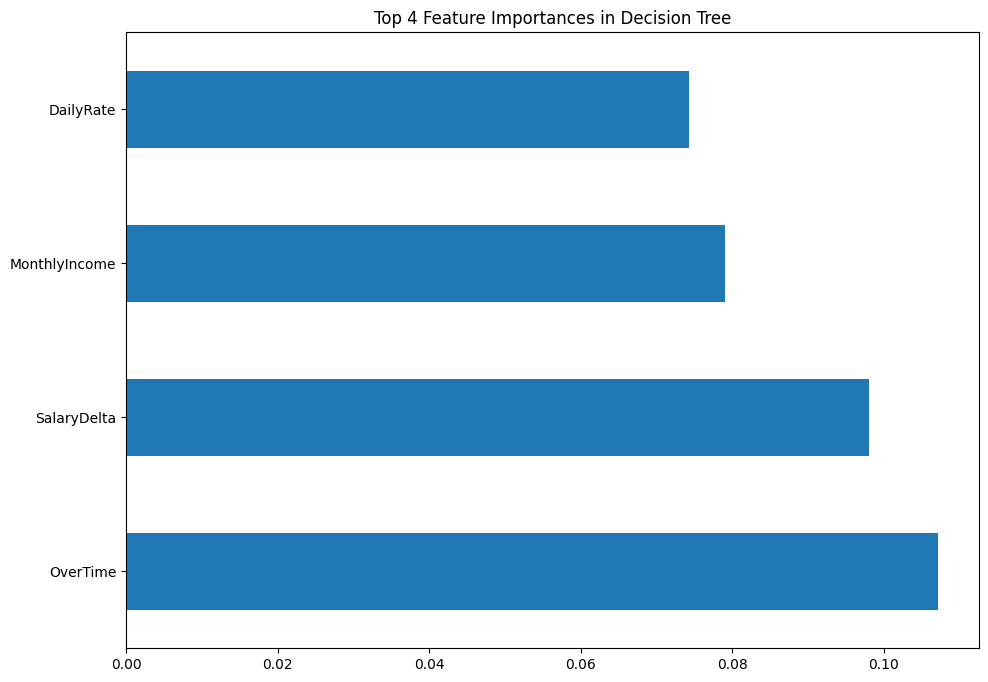

In [110]:
dt_best = dt_gs.best_estimator_.named_steps['dt']
dt_imp = pd.Series(dt_best.feature_importances_, index=X_train.columns)
dt_imp.nlargest(4).plot(kind='barh')
plt.title('Top 4 Feature Importances in Decision Tree')
plt.show()

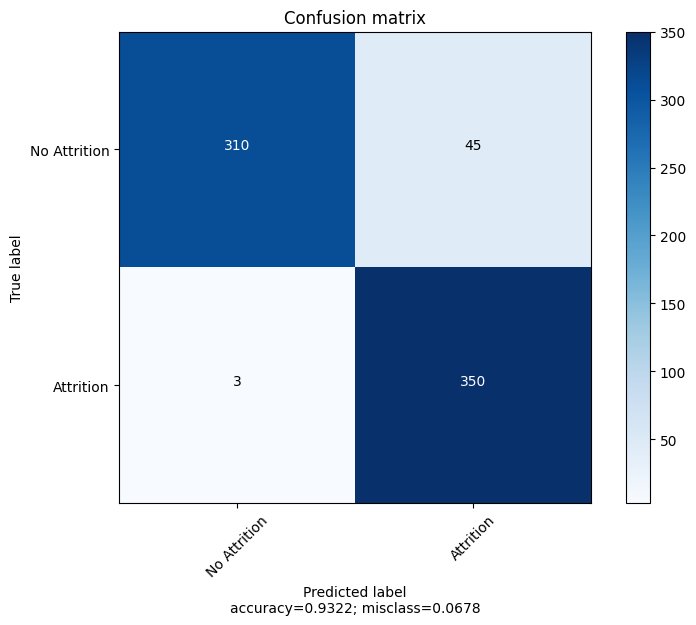

In [111]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [112]:
print(classification_report(y_test, y_pred))
dt_mse = mean_squared_error(y_test, y_pred)
print('MSE: {}'.format(dt_mse))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       355
           1       0.89      0.99      0.94       353

    accuracy                           0.93       708
   macro avg       0.94      0.93      0.93       708
weighted avg       0.94      0.93      0.93       708

MSE: 0.06779661016949153


Un albero di decisione più piccolo può essere preferibile perché riduce l'overfitting, rendendo il modello più capace di generalizzare su dati nuovi. È più interpretabile, il che facilita la comprensione delle decisioni, e richiede meno risorse computazionali sia per l'addestramento che per le previsioni. Inoltre, è più robusto ai dati rumorosi e agli outlier. Tuttavia, un albero più piccolo può avere anche aspetti negativi, come una perdita di accuratezza e un bias elevato, portando a underfitting. Un modello troppo semplice potrebbe non catturare tutte le relazioni complesse nei dati, limitando la sua capacità predittiva.

Accuracy: 0.6878531073446328
Confusion Matrix:
 [[235 120]
 [101 252]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.66      0.68       355
           1       0.68      0.71      0.70       353

    accuracy                           0.69       708
   macro avg       0.69      0.69      0.69       708
weighted avg       0.69      0.69      0.69       708



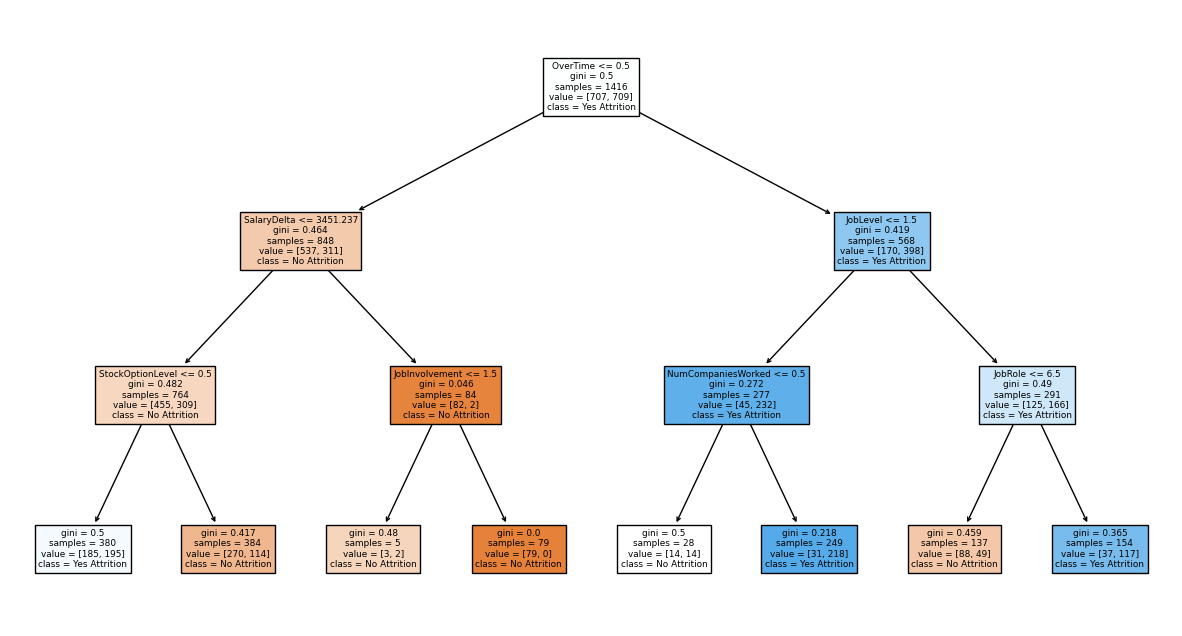

In [113]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf_small = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_small.fit(X_train, y_train)

y_pred_small = clf_small.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_small))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_small))
print("Classification Report:\n", classification_report(y_test, y_pred_small))

plt.figure(figsize=(15, 8))
plot_tree(clf_small, feature_names=X.columns, class_names=['No Attrition', 'Yes Attrition'], filled=True)
plt.show()

# Model Comparison

In [114]:
def model_comparison(mse_1, mse_2):
    d = np.abs(mse_1 - mse_2)
    variance = (mse_1 * (1 - mse_1)) / len(X_test) + (mse_2 * (1 - mse_2)) / len(X_test)
    d_min = d - 1.96 * np.sqrt(variance)
    d_max = d + 1.96 * np.sqrt(variance)
    return (d_min, d_max)

In [115]:
mse_values = [xgb_mse, svm_mse, perc_mse, lr_mse, rfc_mse]
model_names = ['XGBoost', 'SVM', 'Perceptron', 'Logistic Regression', 'Random Forest']

for i in range(len(mse_values)):
  for j in range(i + 1, len(mse_values)):
    print('Interval between {} and {}: {}'.format(model_names[i], model_names[j], np.round(model_comparison(mse_values[i], mse_values[j]), 4)))

Interval between XGBoost and SVM: [0.0378 0.0865]
Interval between XGBoost and Perceptron: [0.2766 0.3506]
Interval between XGBoost and Logistic Regression: [0.1754 0.2427]
Interval between XGBoost and Random Forest: [-0.0161  0.0189]
Interval between SVM and Perceptron: [0.2106 0.2922]
Interval between SVM and Logistic Regression: [0.1091 0.1847]
Interval between SVM and Random Forest: [0.0362 0.0853]
Interval between Perceptron and Logistic Regression: [0.0576 0.1515]
Interval between Perceptron and Random Forest: [0.275  0.3493]
Interval between Logistic Regression and Random Forest: [0.1739 0.2414]


In questa sezione abbiamo analizzato quali modelli fossero simili tra loro e quali avessero differenze rilevanti.

**Random Forest** con **XGBoost** e **Random Forest** con **SVM**  hanno ottenuto risultati piuttosto simili in termini di `accuracy` e `f1-score`.

Anche **XGBoost** con **SVM** e **Perceptron** con **Logistic Regression**.

Al contrario invece **Perceptron** con **XGBoost**, **SVM** e **Random Forest** hanno ottenuto valori abbastanza diversi di `accuracy` e `f1-score`, quindi ci si aspetta che siano significativamente differenti.

# Model Serialization

In [116]:
!mkdir models

#XGB
model_serialize = open("models/xgb-model.mdl", 'wb')
pickle.dump(xgb_gs, model_serialize)
model_serialize.close()

#Logistic Regression
model_serialize = open("models/lr-model.mdl", 'wb')
pickle.dump(lr_gs, model_serialize)
model_serialize.close()

#SVM
model_serialize = open("models/svm-model.mdl", 'wb')
pickle.dump(svm_gs, model_serialize)
model_serialize.close()

#Random Forese
model_serialize = open("models/rf-model.mdl", 'wb')
pickle.dump(rfc_gs, model_serialize)
model_serialize.close()

#Percepron
model_serialize = open("models/pct-model.mdl", 'wb')
pickle.dump(perceptron_cv, model_serialize)
model_serialize.close()

# Neural Networks

In [117]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    plt.ylim([0.4, 1])
    plt.legend()
    plt.show()

In [118]:
print(keras.__version__)
print(tf.__version__)

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def recall_m(y_true, y_pred):
  y_true = K.cast(y_true, 'float32')
  y_pred = K.cast(y_pred, 'float32')
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  y_true = K.cast(y_true, 'float32')
  y_pred = K.cast(y_pred, 'float32')
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_score(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

def nn_build_model():
  model = Sequential([
    Input(shape=[X_train.shape[1]]),  # Correct way to specify the input shape
    Dense(64, kernel_initializer='random_uniform', activation=tf.nn.relu),
    Dropout(0.5),
    Dense(64, kernel_initializer='random_uniform', activation=tf.nn.relu),
    Dropout(0.5),
    Dense(64, kernel_initializer='random_uniform', activation=tf.nn.relu),
    Dropout(0.5),
    Dense(1, kernel_initializer='random_uniform', activation=tf.nn.sigmoid)
  ])

  model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1_score])
  return model

3.4.1
2.17.0


In [119]:
scaler_X = StandardScaler()
std_X_train = scaler_X.fit_transform(X_train.astype(float))
std_X_test = scaler_X.transform(X_test)

std_y_train = to_categorical(y_train)
std_y_test = to_categorical(y_test)

model = nn_build_model()
history = model.fit(std_X_train, y_train, validation_split=0.3, batch_size=128, epochs=250, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
..................................................

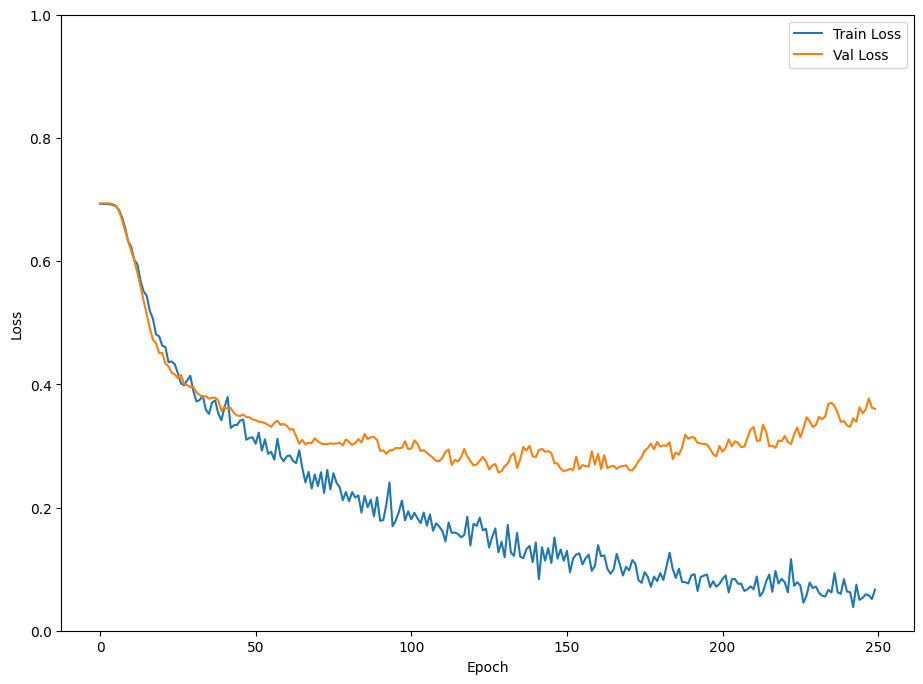

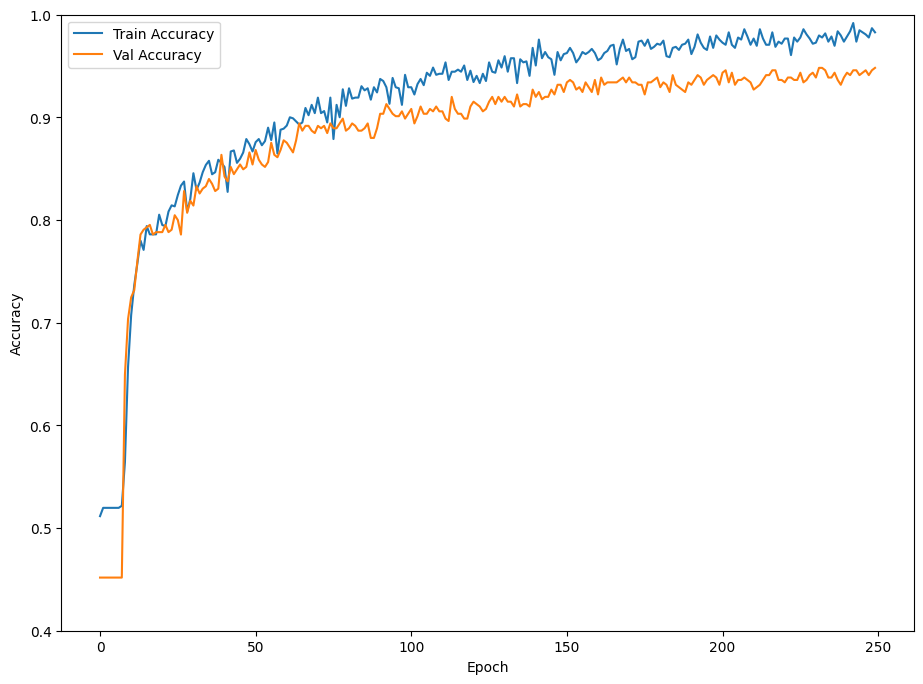

In [120]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [121]:
model.evaluate(scaler_X.transform(X_test), y_test, batch_size=128)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9220 - f1_score: 0.9252 - loss: 0.4437


[0.38559868931770325, 0.9322034120559692, 0.9362356662750244]

In [122]:
y_pred = model.predict(scaler_X.transform(X_test))
y_pred =(y_pred > 0.5)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


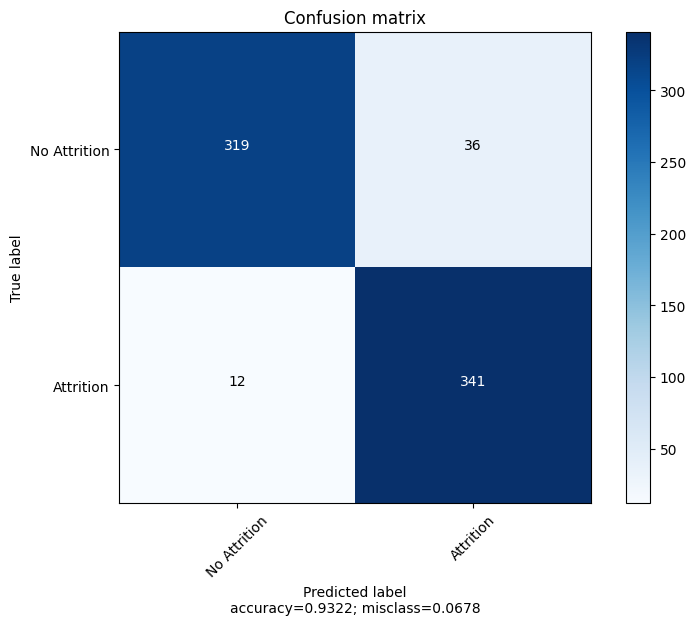

In [123]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names=['No Attrition', 'Attrition'], normalize=False)

In [124]:
pred = model.predict(scaler_X.transform(X_test))
pred = (pred > 0.5)
print(classification_report(y_test, pred))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       355
           1       0.90      0.97      0.93       353

    accuracy                           0.93       708
   macro avg       0.93      0.93      0.93       708
weighted avg       0.93      0.93      0.93       708



# Neural Network save procedure

In [125]:
model.save('models/nn-model.keras')